In [1]:
pd.set_option('display.max_columns', 100)
import os

import pandas as pd
import pyodbc
from dotenv import load_dotenv

load_dotenv()

True

## DB Credentials
Fill these variables in with appropriate credientials if not using dotenv.

In [2]:
server = 'XXX'
database = 'XXX'
username = 'XXX'
password = 'XXX'

## Airport Records
Downloaded a [public dataset](https://ourairports.com/data/]) and saved it to `/data/common/airports.csv`. The utility function below creates a Pandas DataFrame for easy usage.

In [3]:
def get_airports_df():
    path = '/data/common/airports.csv'
    df = pd.read_csv(path, keep_default_na=False)
    return df

In [4]:
airports_df = get_airports_df()
airports_df[airports_df['iata_code'].isin(['ORD', 'MDW', 'YYZ', 'YTZ'])]

id ident            type                                      name  \
16663  1926  CYTZ  medium_airport  Billy Bishop Toronto City Centre Airport   
16729  1990  CYYZ   large_airport   Lester B. Pearson International Airport   
28340  3673  KMDW   large_airport      Chicago Midway International Airport   
28721  3754  KORD   large_airport      Chicago O'Hare International Airport   

       latitude_deg  longitude_deg elevation_ft continent iso_country  \
16663     43.627499     -79.396202          252        NA          CA   
16729     43.677200     -79.630600          569        NA          CA   
28340     41.785999     -87.752403          620        NA          US   
28721     41.978600     -87.904800          672        NA          US   

      iso_region municipality scheduled_service gps_code iata_code local_code  \
16663      CA-ON      Toronto               yes     CYTZ       YTZ              
16729      CA-ON      Toronto               yes     CYYZ       YYZ        YYZ   
28340      US-IL      Chicago               yes     KMDW       MDW        MDW   
28721      US-IL      Chicago               yes     KORD       ORD        ORD   

                                               home_link  \
16663            http://www.torontoport.com/airport.aspx   
16729                               http://www.gtaa.com/   
28340  https://www.flychicago.com/midway/home/pages/d...   
28721  https://www.flychicago.com/ohare/home/pages/de...   

                                          wikipedia_link  \
16663  https://en.wikipedia.org/wiki/Toronto_City_Cen...   
16729  https://en.wikipedia.org/wiki/Toronto_Pearson_...   
28340  https://en.wikipedia.org/wiki/Midway_Internati...   
28721  https://en.wikipedia.org/wiki/O'Hare_Internati...   

                                         keywords  
16663                 YTO, Toronto Island Airport  
16729  YTO, Toronto International Airport, Malton  
28340                                         CHI  
28721                          CHI, Orchard Place

## Hotel Records
This query fetches PC Travel hotel records that do not have associated flights. In other words, these are hotel records that do not appear to be a part of a vacation package. The `BOOKEDBY` column warrants some deeper investigation to figure out which are web-based bookings and which are not.

*Please be skeptical of this for now. It is my best effort but the Pen Air DB is notoriously difficult to understand completely.*

In [5]:
hotel_only_query = """
    SELECT
        h.FOLDERNO,
        h.SUPPNAME,
        h.BookingDate,
        f.ARRIVALPT,
        f.NOOFPASS,
        h.ROOMS,
        h.HOTELNAME,        
        h.TYPE,
        h.DATEIN,
        h.DATEOUT,
        f.TotalBUY,
        f.BOOKEDBY
    from dbo.FolderMaster f
    LEFT JOIN dbo.AirSegDetails a ON f.FOLDERNO = a.FOLDERNO
    JOIN dbo.HotelDetails h ON f.FOLDERNO = h.FOLDERNO and h.SLNO = 1
    join dbo.PassengerMaster p on f.FOLDERNO = p.FOLDERNO and p.SLNO = 1
    where
        CUSTOMERNAME = 'PC Travel'
        AND a.FOLDERNO IS NULL
        AND CURCODE = 'CAD'
        and f.STATUS in (1,2)
        and TOTALBuy > 0 
        and lower(p.EMail) not like '%sandhurstconsulting.com'
        and lower(p.EMail) not like '%travelnationcanada.com'
        and lower(p.EMail) not like '%travelnation.com'
        and lower(p.EMail) not like '%pctravel.ca'
        and len(p.Email) > 0
        and len(ARRIVALPT) = 3
        and ISNUMERIC(ARRIVALPT) = 0
"""

In [6]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
with conn.cursor() as cur:
    cur.execute(hotel_only_query)
    results = cur.fetchall()
conn.close()

In [7]:
columns =[
    'FolderNo',
    'SupplierName',
    'BookingDate',
    'Destination',
    'NumPax',
    'NumRooms',
    'HotelName',
    'RoomType',
    'CheckIn',
    'CheckOut',
    'Total',
    'BookedBy',
]
df_hotel_no_flight = pd.DataFrame.from_records(results, columns=columns)

In [8]:
df_hotel_no_flight.head(2)

FolderNo SupplierName BookingDate Destination  NumPax  NumRooms  \
0    34259         TAAP  2019-03-06         YTO       1         1   
1    10660      EXPEDIA  2018-09-18         YWG       2         1   

                                     HotelName  \
0  DOUBLETREE BY HILTON HOTEL TORONTO DOWNTOWN   
1          Best Western Plus Downtown Winnipeg   

                                            RoomType    CheckIn   CheckOut  \
0                                   ROOM, 1 KING BED 2019-03-07 2019-03-12   
1  Standard Room, 2 Double Beds, Accessible, Refr... 2018-10-26 2018-10-29   

      Total   BookedBy  
0  892.5200  saishford  
1  417.2200  PC Travel

In [9]:
df_hotel_no_flight['booking_window'] = (df_hotel_no_flight['CheckIn'] - df_hotel_no_flight['BookingDate']).dt.days
df_hotel_no_flight['length_of_stay'] = (df_hotel_no_flight['CheckOut'] - df_hotel_no_flight['CheckIn']).dt.days

Remove booking_window < 0, which removed 27 records.

In [10]:
df_hotel_no_flight = df_hotel_no_flight[df_hotel_no_flight.booking_window >= 0]

Last booking date can't be right.

In [11]:
print(f' Booking date minimum value {df_hotel_no_flight.BookingDate.min()}')
print(f' Booking date maximum value {df_hotel_no_flight.BookingDate.max()}')

 Booking date minimum value 2017-11-13 00:00:00
 Booking date maximum value 2020-02-14 00:00:00


In [12]:
print(f' Checkin date minimum value {df_hotel_no_flight.CheckIn.min()}')
print(f' Checkin date maximum value {df_hotel_no_flight.CheckIn.max()}')

 Checkin date minimum value 2018-01-10 00:00:00
 Checkin date maximum value 2020-10-25 00:00:00


I decide to replace 4 with 1 in the "NumRooms" fields, and replace 0 with 1 in the "NumRooms" field, and replace 0 with 1 in the "length_of_stay" field.

In [13]:
df_hotel_no_flight.loc[df_hotel_no_flight.NumRooms == 4, 'NumRooms'] = 1
df_hotel_no_flight.loc[df_hotel_no_flight.NumRooms == 0, 'NumRooms'] = 1
df_hotel_no_flight.loc[df_hotel_no_flight.length_of_stay == 0, 'length_of_stay'] = 1

Get room rate.

In [14]:
df_hotel_no_flight["Total"] = df_hotel_no_flight.Total.astype(float)
df_hotel_no_flight['room_rate'] = df_hotel_no_flight["Total"] / df_hotel_no_flight["length_of_stay"] / df_hotel_no_flight["NumRooms"]

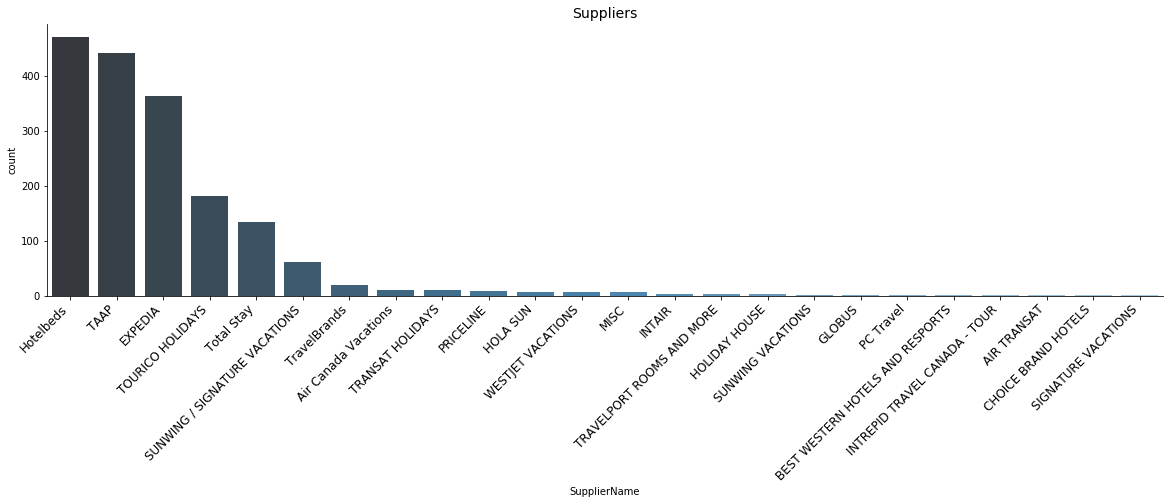

In [16]:
plt.figure(figsize=(20,5))
sns.countplot(x='SupplierName', data=df_hotel_no_flight, order=df_hotel_no_flight['SupplierName'].value_counts().index, palette="Blues_d")
plt.title('Suppliers', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

Merge this data frame with airport_df, so I could get city names for easy understanding. However, found 23 records missing in airports_df. It is because there were some IATA code that represent the cities such as YTO, NYC, WAS, LON, PAR and so on, in the PenAir data.

In [17]:
df_hotel_no_flight = pd.merge(df_hotel_no_flight, airports_df[['iata_code', 'municipality', 'iso_country']], how='left', left_on='Destination', right_on='iata_code').drop(columns = ['iata_code'])

In [18]:
df_hotel_no_flight.drop_duplicates(subset ='FolderNo', keep = 'last', inplace = True)

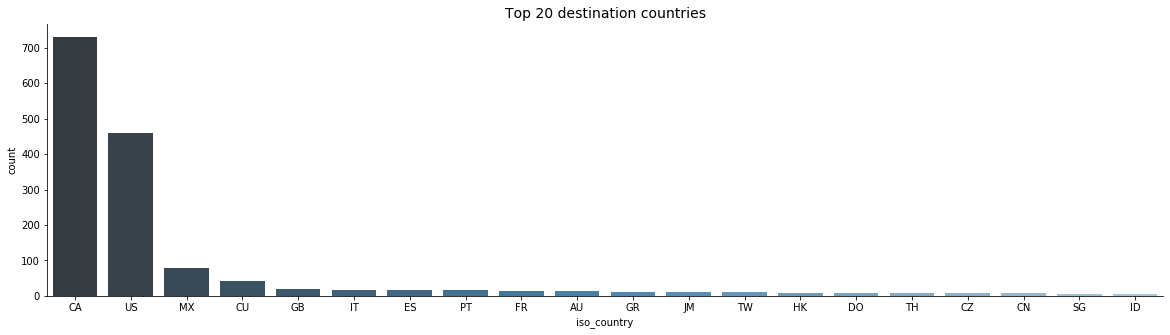

In [19]:
plt.figure(figsize=(20,5))
sns.countplot(x='iso_country', data=df_hotel_no_flight, order=df_hotel_no_flight['iso_country'].value_counts()[:20].index, palette="Blues_d")
plt.title('Top 20 destination countries', size=14)

# plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

PC Travel customers who book hotels only are largely traveling within Canada.

In [26]:
euro_country = df_hotel_no_flight.loc[(df_hotel_no_flight['iso_country'] == 'GB') | (df_hotel_no_flight['iso_country'] == 'IT') | (df_hotel_no_flight['iso_country'] == 'ES') | (df_hotel_no_flight['iso_country'] == 'FR') | (df_hotel_no_flight['iso_country'] == 'PT') | (df_hotel_no_flight['iso_country'] == 'GR')]

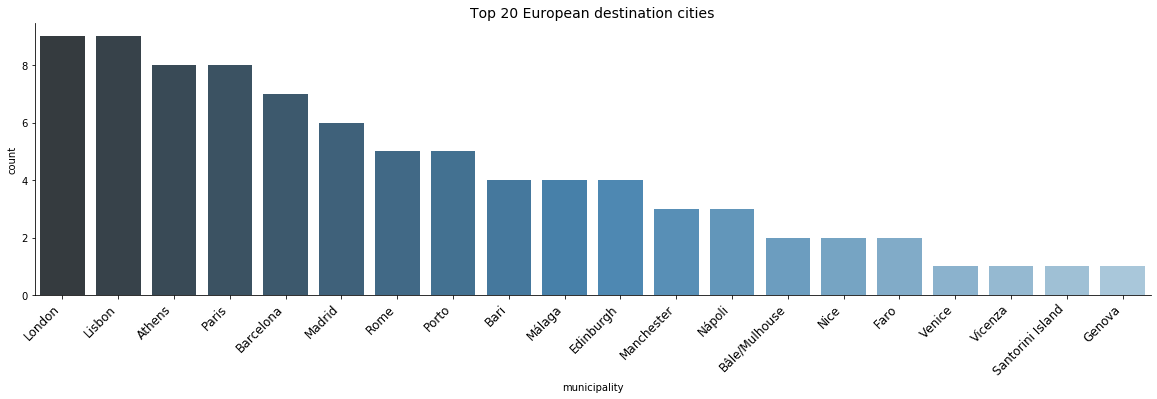

In [29]:
plt.figure(figsize=(20,5))
sns.countplot(x='municipality', data=euro_country, order=euro_country['municipality'].value_counts()[:20].index, palette="Blues_d")
plt.title('Top 20 European destination cities', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

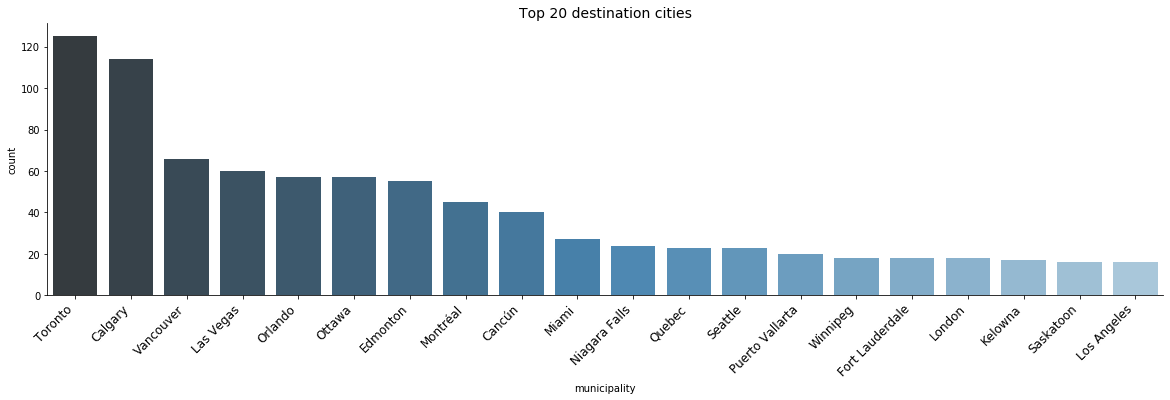

In [30]:
plt.figure(figsize=(20,5))
sns.countplot(x='municipality', data=df_hotel_no_flight, order=df_hotel_no_flight['municipality'].value_counts()[:20].index, palette="Blues_d")
plt.title('Top 20 destination cities', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

Replace white space with NaN.

In [31]:
df_hotel_no_flight['HotelName'] = df_hotel_no_flight['HotelName'].replace(r'^\s*$', np.nan, regex=True)

Where they stay in Toronto?

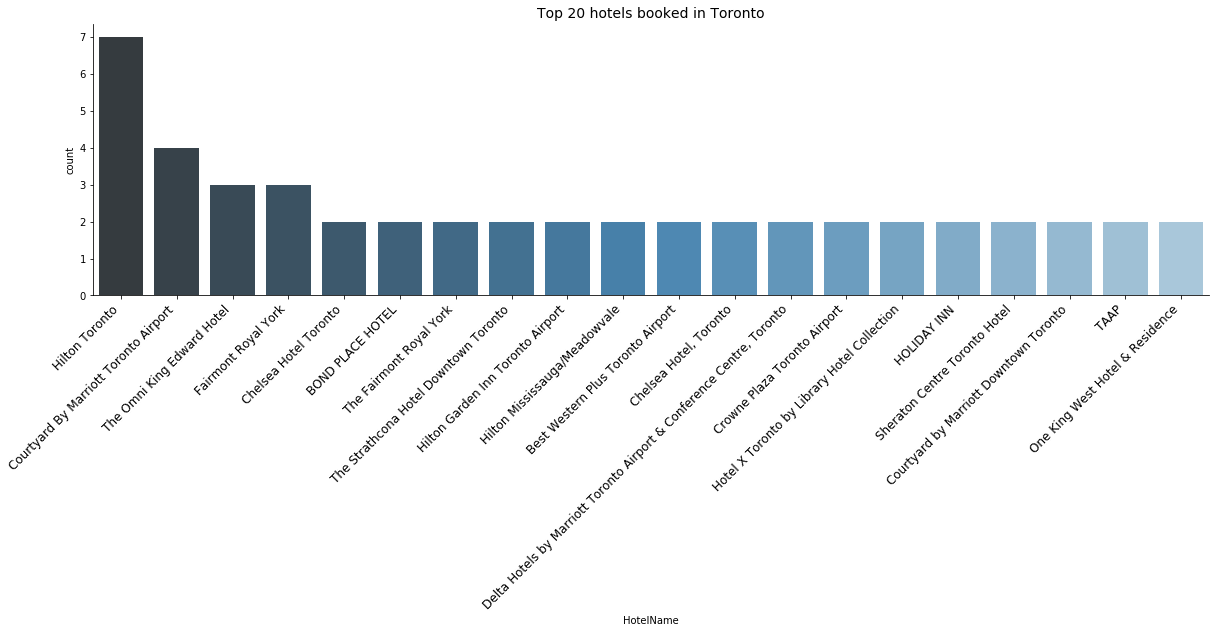

In [32]:
plt.figure(figsize=(20,5))
sns.countplot(x='HotelName', data=df_hotel_no_flight.loc[(df_hotel_no_flight['Destination'] == 'YTO') | (df_hotel_no_flight['municipality'] == 'Toronto')], order=df_hotel_no_flight.loc[(df_hotel_no_flight['Destination'] == 'YTO') | (df_hotel_no_flight['municipality'] == 'Toronto')].HotelName.value_counts()[:20].index, palette="Blues_d")
plt.title('Top 20 hotels booked in Toronto', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

As you can see, there are too little data to make it meaningful.

Top booked cities are Toronto, Calgary and Vancouver, so we are going to look at these 3 cities' hotel room rate.

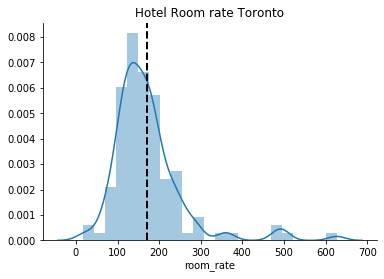

In [33]:
sns.distplot(df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Toronto']['room_rate'])
plt.axvline(df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Toronto']['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Hotel Room rate Toronto')
sns.despine();

In [34]:
df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Toronto']['room_rate'].describe()

count    125.000000
mean     171.768371
std       87.145873
min       17.257500
25%      124.085000
50%      155.480000
75%      192.040000
max      627.030000
Name: room_rate, dtype: float64

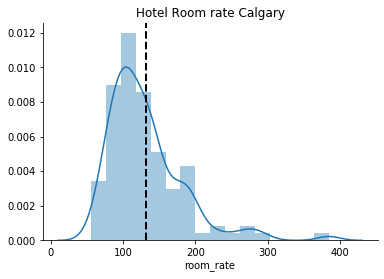

In [35]:
sns.distplot(df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Calgary']['room_rate'])
plt.axvline(df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Calgary']['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Hotel Room rate Calgary')
sns.despine();

In [36]:
df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Calgary']['room_rate'].describe()

count    114.000000
mean     131.405519
std       52.353955
min       56.260000
25%       97.290000
50%      117.775000
75%      147.720000
max      384.750000
Name: room_rate, dtype: float64

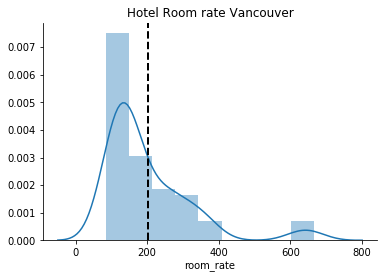

In [37]:
sns.distplot(df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Vancouver']['room_rate'])
plt.axvline(df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Vancouver']['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Hotel Room rate Vancouver')
sns.despine();

In [38]:
df_hotel_no_flight.loc[df_hotel_no_flight['municipality'] == 'Vancouver']['room_rate'].describe()

count     66.000000
mean     202.359934
std      125.270813
min       84.640000
25%      117.562500
50%      156.060000
75%      249.242500
max      666.360000
Name: room_rate, dtype: float64

There is no surprise that Vancouver has the highest average hotel room rate.

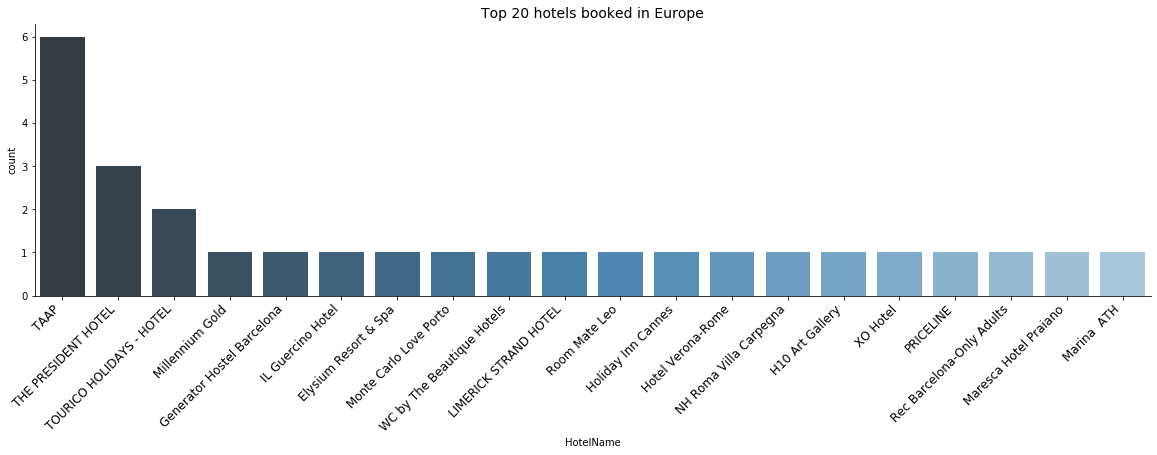

In [40]:
plt.figure(figsize=(20,5))
sns.countplot(x='HotelName', data=euro_country, order=euro_country['HotelName'].value_counts()[:20].index, palette="Blues_d")
plt.title('Top 20 hotels booked in Europe', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

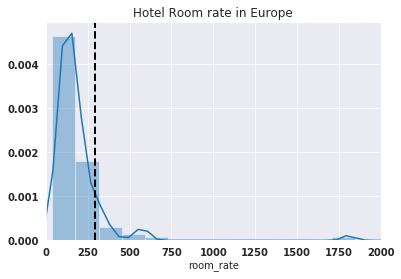

In [171]:
sns.distplot(euro_country['room_rate'])
plt.axvline(euro_country['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Hotel Room rate in Europe')
plt.xlim(0, 2000)
sns.despine();

In [172]:
euro_country['room_rate'].describe()

count      96.000000
mean      294.395323
std       794.316386
min        36.373333
25%       104.265000
50%       151.981667
75%       217.292000
max      6996.160000
Name: room_rate, dtype: float64

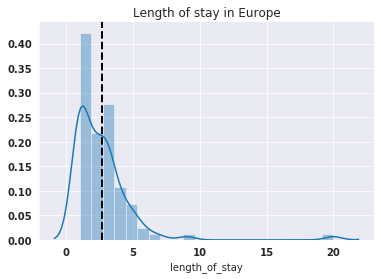

In [174]:
sns.distplot(euro_country['length_of_stay'])
plt.axvline(euro_country['length_of_stay'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Length of stay in Europe')
# plt.xlim(0, 2000)
sns.despine();

In [175]:
euro_country['length_of_stay'].describe()

count    96.000000
mean      2.645833
std       2.379647
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      20.000000
Name: length_of_stay, dtype: float64

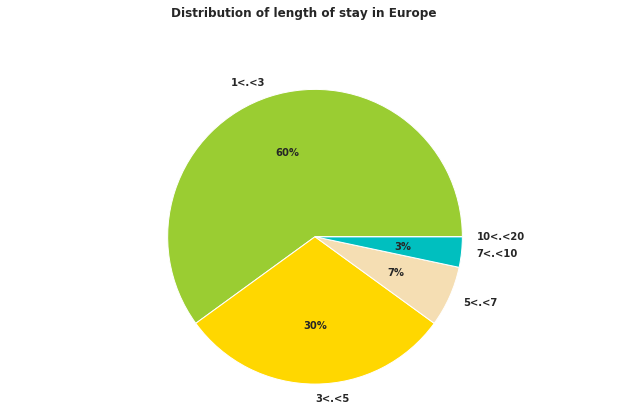

In [178]:
stay_range = [1, 3, 5, 7, 10, 20]
count_stay = []
for i, stay in enumerate(stay_range):
    if i == 0: continue
    val = euro_country[(euro_country['length_of_stay'] < stay) &
                       (euro_country['length_of_stay'] > stay_range[i-1])]['length_of_stay'].count()
    count_stay.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(stay_range[i-1], s) for i,s in enumerate(stay_range) if i != 0]
sizes  = count_stay
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of length of stay in Europe", ha='center', fontsize = 12);

In [225]:
euro_country['booking_window'].describe()

count     96.00000
mean      89.34375
std       75.82998
min        0.00000
25%       28.75000
50%       73.00000
75%      124.75000
max      324.00000
Name: booking_window, dtype: float64

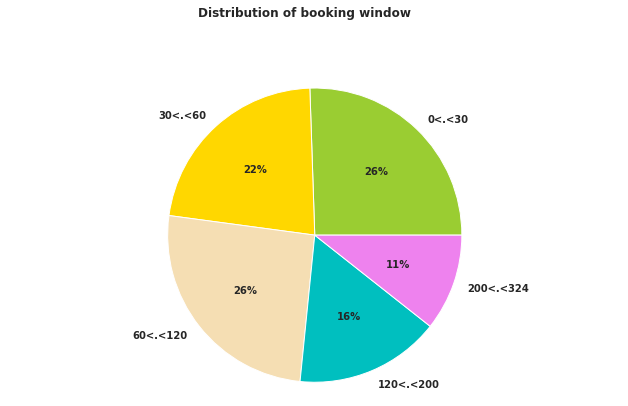

In [228]:
booking_window_range = [0, 30, 60, 120, 200, 324]
count_booking_window = []
for i, booking_window in enumerate(booking_window_range):
    if i == 0: continue
    val = euro_country[(euro_country['booking_window'] < booking_window) &
                       (euro_country['booking_window'] > booking_window_range[i-1])]['booking_window'].count()
    count_booking_window.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(booking_window_range[i-1], s) for i,s in enumerate(booking_window_range) if i != 0]
sizes  = count_booking_window
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of booking window", ha='center', fontsize = 12);

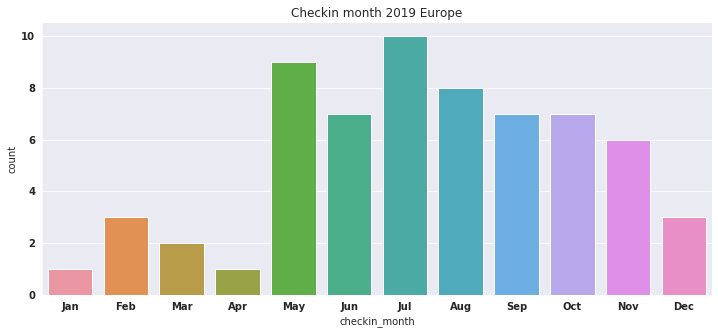

In [181]:
euro_country['checkin_year'] = euro_country['CheckIn'].dt.year
euro_country['checkin_month'] = euro_country['CheckIn'].dt.strftime('%b')
plt.figure(figsize=(12,5))
sns.countplot(x='checkin_month', order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], data =euro_country.loc[euro_country['checkin_year'] == 2019])
plt.title('Checkin month 2019 Europe', size=12)
sns.despine();

In [183]:
euro_country['iso_country'].value_counts()

GB    20
IT    17
ES    17
PT    16
FR    14
GR    12
Name: iso_country, dtype: int64

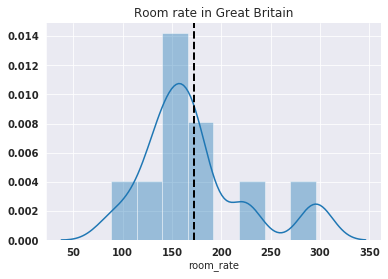

In [191]:
sns.distplot(euro_country.loc[(euro_country['iso_country'] == 'GB') & (euro_country['room_rate'] <= 500)]['room_rate'])
plt.axvline(euro_country.loc[(euro_country['iso_country'] == 'GB') & (euro_country['room_rate'] <= 500)]['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Room rate in Great Britain')
#plt.xlim(0, 2000)
sns.despine();

In [193]:
euro_country.loc[(euro_country['iso_country'] == 'GB') & (euro_country['room_rate'] <= 500)]['room_rate'].describe()

count     19.000000
mean     171.879618
std       54.805972
min       88.228571
25%      142.915000
50%      161.765000
75%      181.350000
max      295.915000
Name: room_rate, dtype: float64

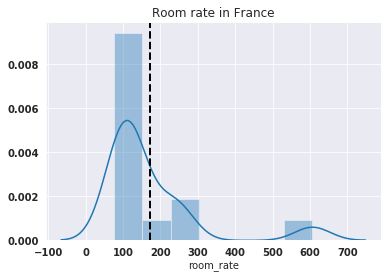

In [195]:
sns.distplot(euro_country.loc[euro_country['iso_country'] == 'FR']['room_rate'])
plt.axvline(euro_country.loc[euro_country['iso_country'] == 'FR']['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Room rate in France')
#plt.xlim(0, 2000)
sns.despine();

In [196]:
euro_country.loc[euro_country['iso_country'] == 'FR']['room_rate'].describe()

count     14.000000
mean     172.041976
std      138.060999
min       75.750000
25%       95.281250
50%      127.778333
75%      197.257000
max      606.720000
Name: room_rate, dtype: float64

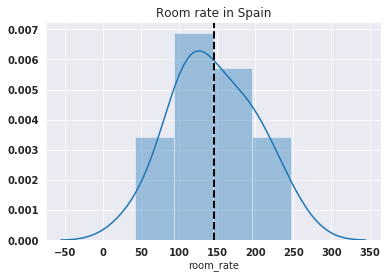

In [197]:
sns.distplot(euro_country.loc[euro_country['iso_country'] == 'ES']['room_rate'])
plt.axvline(euro_country.loc[euro_country['iso_country'] == 'ES']['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Room rate in Spain')
#plt.xlim(0, 2000)
sns.despine();

In [198]:
euro_country.loc[euro_country['iso_country'] == 'ES']['room_rate'].describe()

count     17.000000
mean     145.362288
std       53.901013
min       41.863333
25%      108.810000
50%      127.000000
75%      183.100000
max      247.425000
Name: room_rate, dtype: float64

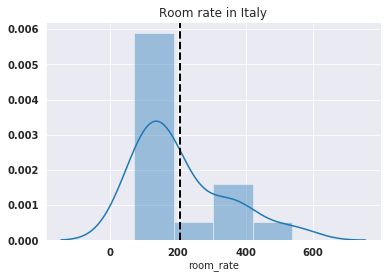

In [204]:
sns.distplot(euro_country.loc[(euro_country['iso_country'] == 'IT') & (euro_country['room_rate'] <= 3000)]['room_rate'])
plt.axvline(euro_country.loc[(euro_country['iso_country'] == 'IT') & (euro_country['room_rate'] <= 3000)]['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Room rate in Italy')
#plt.xlim(0, 2000)
sns.despine();

In [205]:
euro_country.loc[(euro_country['iso_country'] == 'IT') & (euro_country['room_rate'] <= 3000)].room_rate.describe()

count     16.000000
mean     206.976896
std      134.989225
min       70.705000
25%      117.837500
50%      165.427500
75%      277.875000
max      538.232000
Name: room_rate, dtype: float64

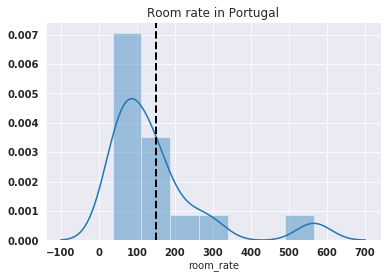

In [211]:
sns.distplot(euro_country.loc[(euro_country['iso_country'] == 'PT') & (euro_country['room_rate'] <= 1000)]['room_rate'])
plt.axvline(euro_country.loc[(euro_country['iso_country'] == 'PT') & (euro_country['room_rate'] <= 1000)]['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Room rate in Portugal')
#plt.xlim(0, 2000)
sns.despine();

In [213]:
euro_country.loc[(euro_country['iso_country'] == 'PT') & (euro_country['room_rate'] <= 1000)].room_rate.describe()

count     15.000000
mean     149.685667
std      135.747300
min       36.373333
25%       64.561667
50%      106.592500
75%      163.901667
max      566.250000
Name: room_rate, dtype: float64

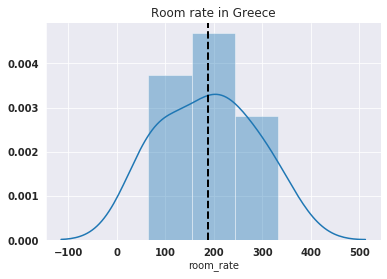

In [216]:
sns.distplot(euro_country.loc[euro_country['iso_country'] == 'GR']['room_rate'])
plt.axvline(euro_country.loc[euro_country['iso_country'] == 'GR']['room_rate'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Room rate in Greece')
#plt.xlim(0, 2000)
sns.despine();

In [215]:
euro_country.loc[euro_country['iso_country'] == 'GR']['room_rate'].describe()

count     12.000000
mean     187.355528
std       93.148970
min       65.130000
25%       92.988333
50%      201.445000
75%      234.448750
max      332.233333
Name: room_rate, dtype: float64

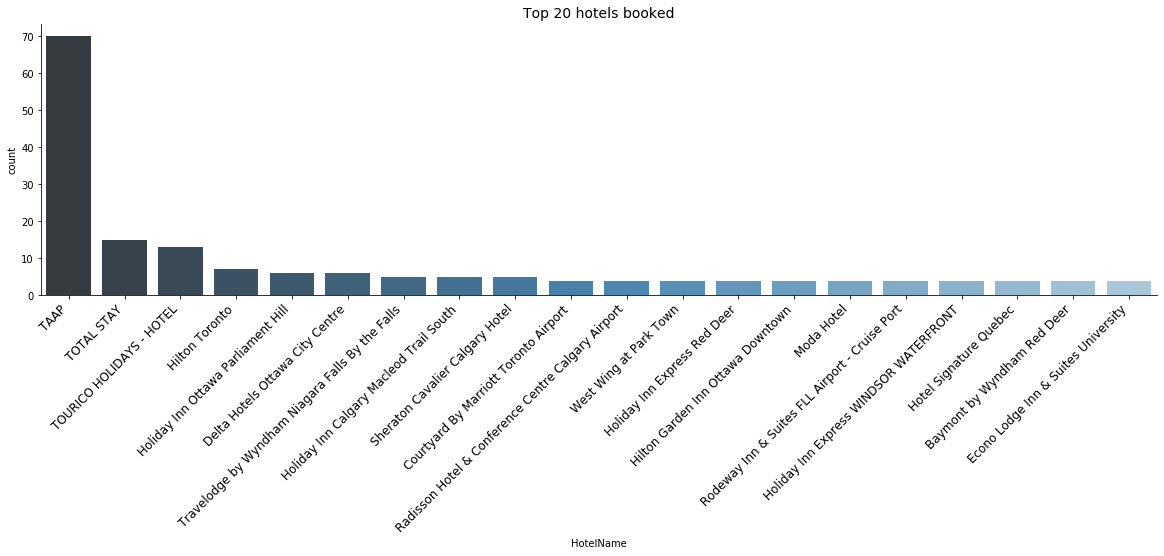

In [41]:
plt.figure(figsize=(20,5))
sns.countplot(x='HotelName', data=df_hotel_no_flight, order=df_hotel_no_flight['HotelName'].value_counts()[:20].index, palette="Blues_d")
plt.title('Top 20 hotels booked', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

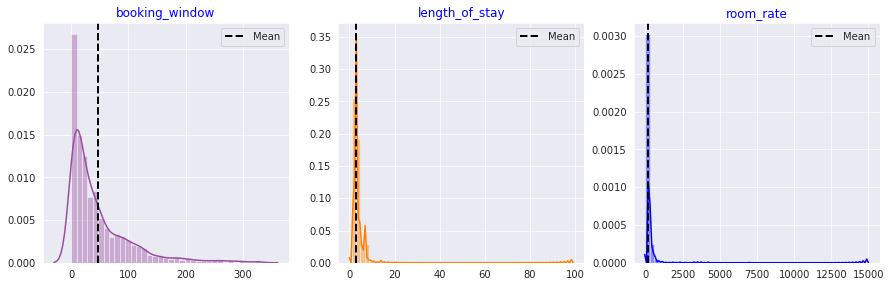

In [42]:
import itertools
cols = ['booking_window', 'length_of_stay', 'room_rate']
length = len(cols)
cs     = [(0.596078431372549, 0.3058823529411765, 0.6392156862745098),
          (1.0, 0.4980392156862745, 0.0),"b"]

sns.set_style("darkgrid")
plt.figure(figsize = (15,15))
for i,j,k in itertools.zip_longest(cols,range(length), cs):
    plt.subplot(length/1,length/1,j+1)
    sns.distplot(df_hotel_no_flight[i],color = k)
    plt.axvline(df_hotel_no_flight[i].mean(),linewidth  = 2 ,
                linestyle = "dashed",color = "k" ,
                label = "Mean")
    plt.legend(loc = "best")
    plt.title(i,color = "b")
    plt.xlabel("");

In [43]:
df_hotel_no_flight[['booking_window', 'length_of_stay', 'room_rate']].describe().T

count        mean         std       min       25%     50%  \
booking_window  1740.0   47.779310   56.121660  0.000000    9.0000   28.00   
length_of_stay  1740.0    2.797701    3.078687  1.000000    1.0000    3.00   
room_rate       1740.0  197.353646  451.879638  3.571429  102.8875  140.76   

                    75%      max  
booking_window   66.000    331.0  
length_of_stay    3.000     98.0  
room_rate       197.245  14952.2

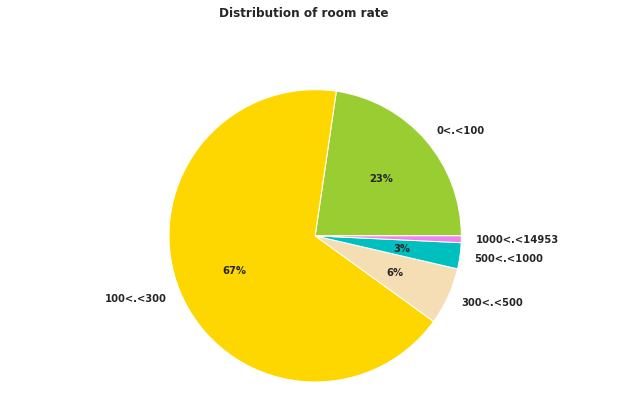

In [44]:
price_range = [0, 100, 300, 500, 1000, 14953]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = df_hotel_no_flight[(df_hotel_no_flight['room_rate'] < price) &
                       (df_hotel_no_flight['room_rate'] > price_range[i-1])]['room_rate'].count()
    count_price.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of room rate", ha='center', fontsize = 12);

67% of these bookings room rate were at 100-300 dollars range. 90% of the customers will not pay over 300 dollars per night.

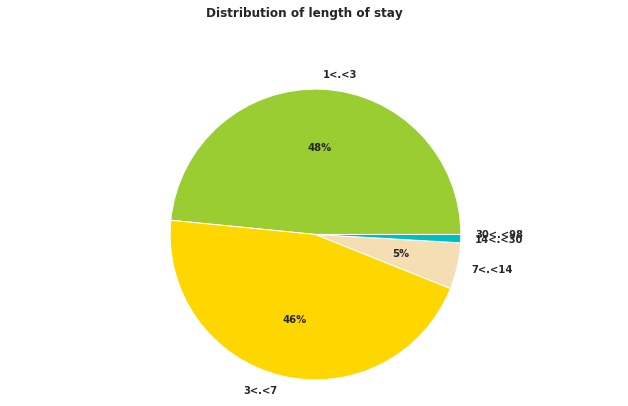

In [45]:
stay_range = [1, 3, 7, 14, 30, 98]
count_stay = []
for i, stay in enumerate(stay_range):
    if i == 0: continue
    val = df_hotel_no_flight[(df_hotel_no_flight['length_of_stay'] < stay) &
                       (df_hotel_no_flight['length_of_stay'] > stay_range[i-1])]['length_of_stay'].count()
    count_stay.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(stay_range[i-1], s) for i,s in enumerate(stay_range) if i != 0]
sizes  = count_stay
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of length of stay", ha='center', fontsize = 12);

94% of these bookings were in the stay range from 1 to 7 days. They do not seem to be exotic vacations.

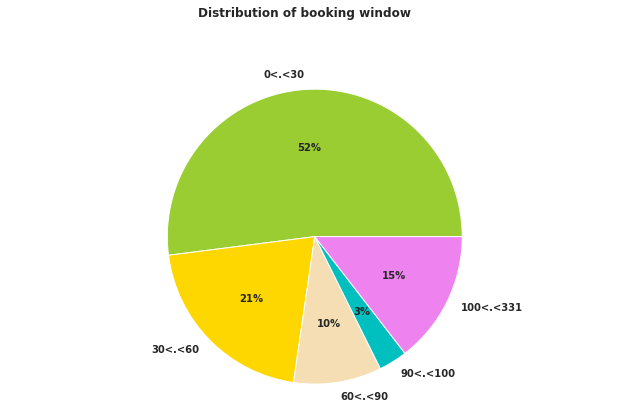

In [46]:
booking_window_range = [0, 30, 60, 90, 100, 331]
count_booking_window = []
for i, booking_window in enumerate(booking_window_range):
    if i == 0: continue
    val = df_hotel_no_flight[(df_hotel_no_flight['booking_window'] < booking_window) &
                       (df_hotel_no_flight['booking_window'] > booking_window_range[i-1])]['booking_window'].count()
    count_booking_window.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(booking_window_range[i-1], s) for i,s in enumerate(booking_window_range) if i != 0]
sizes  = count_booking_window
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of booking window", ha='center', fontsize = 12);

Over 73% of the customers booked within 2 months in advance.

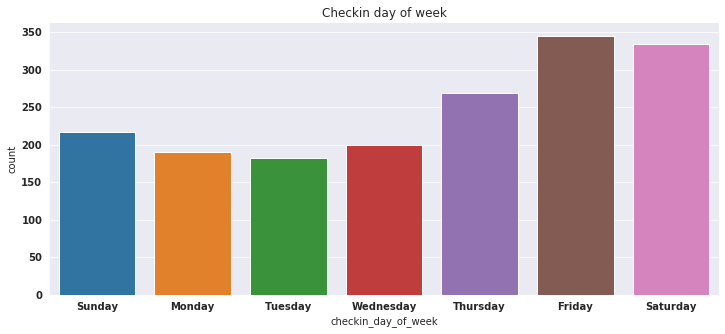

In [47]:
df_hotel_no_flight['checkin_day_of_week'] = df_hotel_no_flight['CheckIn'].dt.day_name()
plt.figure(figsize=(12,5))
sns.countplot(x='checkin_day_of_week', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data =df_hotel_no_flight)
plt.title('Checkin day of week', size=12)
sns.despine();

Many of these bookings look like weekend getaways.

In [48]:
df_booking = df_hotel_no_flight.BookingDate.value_counts().reset_index()
df_booking = df_booking.rename(columns={'index': 'booking_date', 'BookingDate': 'count'})
df_booking = df_booking.sort_values(by='booking_date')

In [49]:
import plotly.express as px

fig = px.line(df_booking, x='booking_date', y='count')
fig.update_layout(title_text="Number of bookings time series")
fig.show()

The problems: 

* We have too little data to make this chart pretty.
* The data prior to Oct 2018 is problematic.
* Therefore, when we compare month over month or quarter over quarter, we will only use data that check in date is in 2019.

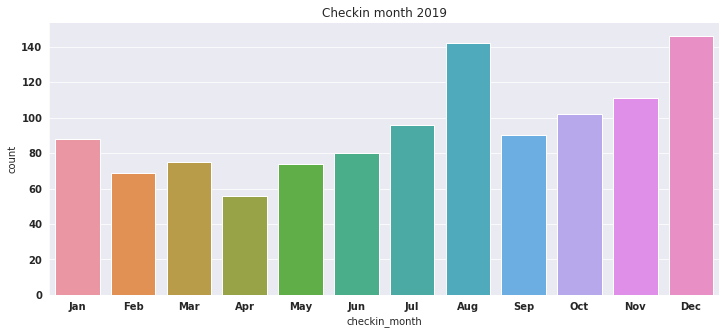

In [50]:
df_hotel_no_flight['checkin_year'] = df_hotel_no_flight['CheckIn'].dt.year
df_hotel_no_flight['checkin_month'] = df_hotel_no_flight['CheckIn'].dt.strftime('%b')
plt.figure(figsize=(12,5))
sns.countplot(x='checkin_month', order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], data =df_hotel_no_flight.loc[df_hotel_no_flight['checkin_year'] == 2019])
plt.title('Checkin month 2019', size=12)
sns.despine();

It is within the expectation that more customers travel in Aug and Dec than the other months. Where they go in Aug and where they go in Dec?

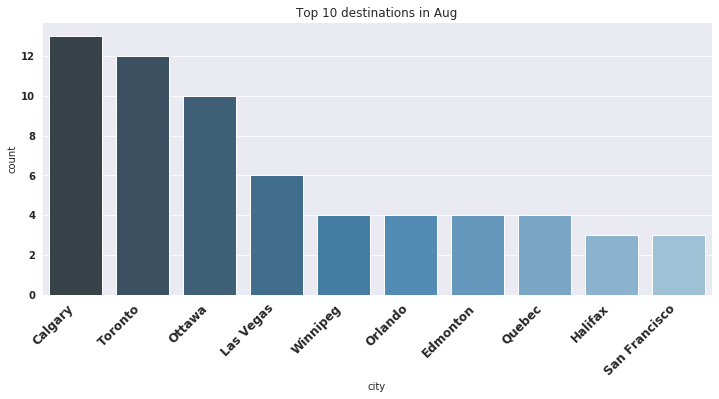

In [51]:
df_aug = df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_month'] == 'Aug') & (df_hotel_no_flight['checkin_year'] == 2019)]['municipality'].value_counts()[:10].reset_index()
plt.figure(figsize=(12,5))
df_aug = df_aug.rename(columns={'index': 'city', 'municipality': 'count'})
sns.barplot("city", y="count", data=df_aug, palette="Blues_d")
plt.xticks(fontsize='large')
plt.title('Top 10 destinations in Aug', size=12)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

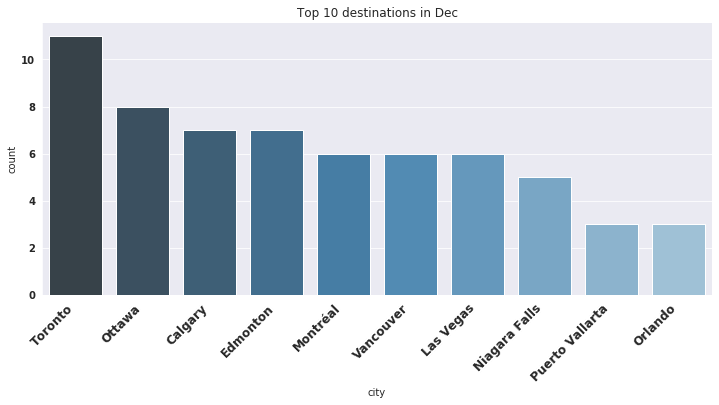

In [52]:
df_dec = df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_month'] == 'Dec') & (df_hotel_no_flight['checkin_year'] == 2019)]['municipality'].value_counts()[:10].reset_index()
plt.figure(figsize=(12,5))
df_dec = df_dec.rename(columns={'index': 'city', 'municipality': 'count'})
sns.barplot("city", y="count", data=df_dec, palette="Blues_d")
plt.xticks(fontsize='large')
plt.title('Top 10 destinations in Dec', size=12)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

Which quarter PC Travel customers like to spend money?

In [53]:
df_hotel_no_flight['checkin_quarter'] = df_hotel_no_flight['CheckIn'].dt.quarter

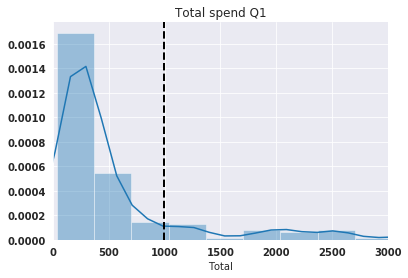

In [54]:
sns.distplot(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 1) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 1) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend Q1')
plt.xlim(0, 3000)
sns.despine();

In [55]:
df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 1) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].describe()

count      232.000000
mean       994.342716
std       2005.655652
min         34.780000
25%        178.292500
50%        334.395000
75%        721.617500
max      16725.720000
Name: Total, dtype: float64

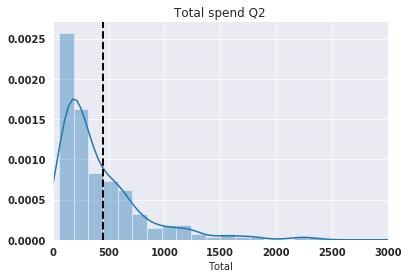

In [56]:
sns.distplot(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 2) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 2) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend Q2')
plt.xlim(0, 3000)
sns.despine();

In [57]:
df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 2) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].describe()

count     210.000000
mean      451.346619
std       503.664642
min        55.660000
25%       159.092500
50%       283.550000
75%       560.925000
max      4128.460000
Name: Total, dtype: float64

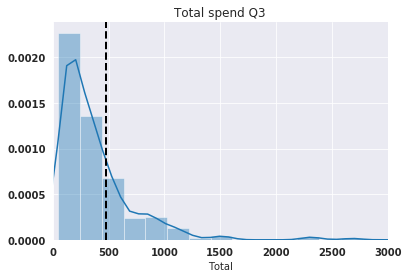

In [58]:
sns.distplot(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 3) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 3) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend Q3')
plt.xlim(0, 3000)
sns.despine();

In [59]:
df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 3) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].describe()

count     328.000000
mean      476.516159
std       831.280347
min        50.000000
25%       152.910000
50%       285.505000
75%       488.217500
max      9787.160000
Name: Total, dtype: float64

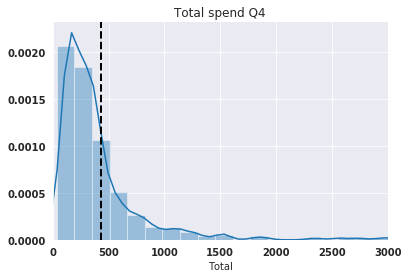

In [60]:
sns.distplot(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 4) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 4) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend Q4')
plt.xlim(0, 3000)
sns.despine();

In [61]:
df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 4) & (df_hotel_no_flight['checkin_year'] == 2019)]['Total'].describe()

count     359.000000
mean      427.729638
std       587.703678
min        36.190000
25%       165.870000
50%       293.970000
75%       431.945000
max      7915.540000
Name: Total, dtype: float64

Average total spending in hotel bookings by quarter. Customers are most willing to spend money in the first quarter of the year.

* First quarter: 994 dollars
* Second quarter: 451 dollars
* Third quarter: 476 dollars
* Fourth quarter: 427 dollars

Since there are quite significant discrepancy spending by quarter. Let's say where the customers spend most in each quarter.

In general, customers do not necessarily travel more in the first quarter, however, they do travel to more exotic destinations such as Cancun, Florida.

Top 10 booked cities in first quarter

In [62]:
quarter_1 = df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 1) & (df_hotel_no_flight['checkin_year'] == 2019)]['municipality'].value_counts().reset_index()
quarter_1.rename(columns={'index': 'city', 'municipality': 'count'}, inplace=True)
quarter_1.head(10)

city  count
0          Toronto     19
1        Las Vegas     13
2           Cancún     13
3         Edmonton     10
4          Orlando      8
5        Vancouver      8
6           Ottawa      8
7          Calgary      8
8  Puerto Vallarta      7
9            Miami      7

Top 10 booked cities in second quarter

In [63]:
quarter_2 = df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 2) & (df_hotel_no_flight['checkin_year'] == 2019)]['municipality'].value_counts().reset_index()
quarter_2.rename(columns={'index': 'city', 'municipality': 'count'}, inplace=True)
quarter_2.head(10)

city  count
0    Calgary     19
1    Toronto     11
2  Vancouver     11
3   Montréal      9
4    Windsor      7
5    Orlando      7
6   Edmonton      7
7  Las Vegas      5
8     Ottawa      5
9     Cancún      4

Top 10 booked cities in third quarter

In [64]:
quarter_3 = df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 3) & (df_hotel_no_flight['checkin_year'] == 2019)]['municipality'].value_counts().reset_index()
quarter_3.rename(columns={'index': 'city', 'municipality': 'count'}, inplace=True)
quarter_3.head(10)

city  count
0        Calgary     24
1        Toronto     21
2         Ottawa     18
3       Montréal     13
4      Las Vegas     12
5       Edmonton     10
6        Orlando      8
7         London      7
8         Quebec      6
9  Niagara Falls      6

Top 10 booked cities in fourth quarter

In [65]:
quarter_4 = df_hotel_no_flight.loc[(df_hotel_no_flight['checkin_quarter'] == 4) & (df_hotel_no_flight['checkin_year'] == 2019)]['municipality'].value_counts().reset_index()
quarter_4.rename(columns={'index': 'city', 'municipality': 'count'}, inplace=True)
quarter_4.head(10)

city  count
0        Toronto     41
1        Calgary     27
2      Las Vegas     17
3        Orlando     16
4         Ottawa     14
5      Vancouver     14
6       Edmonton     10
7  Niagara Falls     10
8       Montréal     10
9       Red Deer      6

In [66]:
df_hotel_no_flight = df_hotel_no_flight[df_hotel_no_flight.BookedBy != 'Online']
df_hotel_no_flight.loc[df_hotel_no_flight['BookedBy'] == 'PC Travel', 'how_to_book'] = 'online booking'
df_hotel_no_flight.loc[df_hotel_no_flight['BookedBy'] != 'PC Travel', 'how_to_book'] = 'phone booking'

In [67]:
df_hotel_no_flight['how_to_book'].value_counts() / df_hotel_no_flight.shape[0]

online booking    0.61211
phone booking     0.38789
Name: how_to_book, dtype: float64

61% of these bookings were booked through PC Travel website, and 39% of these bookings were booked by making a phone call.

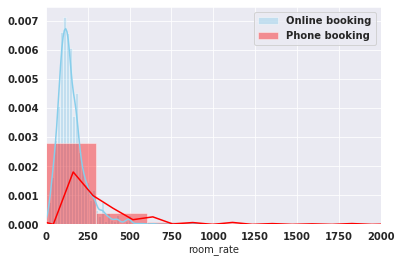

In [68]:
sns.distplot(df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'online booking']['room_rate'] , color="skyblue", label="Online booking")
sns.distplot(df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'phone booking']['room_rate'] , color="red", label="Phone booking")
plt.xlim(0, 2000)
plt.legend();

In [69]:
df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'online booking']['room_rate'].describe()

count    1021.000000
mean      153.939490
std        90.902241
min        14.285714
25%        98.503333
50%       134.100000
75%       183.200000
max       894.000000
Name: room_rate, dtype: float64

In [70]:
df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'phone booking']['room_rate'].describe()

count      647.000000
mean       267.656263
std        725.597129
min          3.571429
25%        110.876250
50%        154.560000
75%        231.616667
max      14952.200000
Name: room_rate, dtype: float64

Customers pay way more to make a booking on the phone than book online.

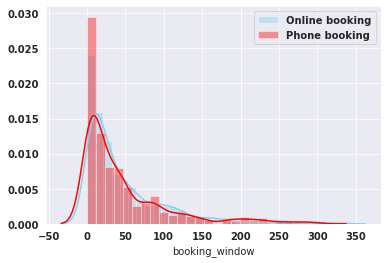

In [71]:
sns.distplot(df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'online booking']['booking_window'] , color="skyblue", label="Online booking")
sns.distplot(df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'phone booking']['booking_window'] , color="red", label="Phone booking")
#plt.xlim(0, 2000)
plt.legend();

In [72]:
df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'online booking']['booking_window'].describe()

count    1021.000000
mean       47.094025
std        53.572628
min         0.000000
25%        10.000000
50%        28.000000
75%        64.000000
max       331.000000
Name: booking_window, dtype: float64

In [73]:
df_hotel_no_flight.loc[df_hotel_no_flight["how_to_book"] == 'phone booking']['booking_window'].describe()

count    647.000000
mean      46.131376
std       58.383989
min        0.000000
25%        7.000000
50%       24.000000
75%       59.000000
max      304.000000
Name: booking_window, dtype: float64

There is no significant difference on booking window when customers make booking online vs. by phone. 

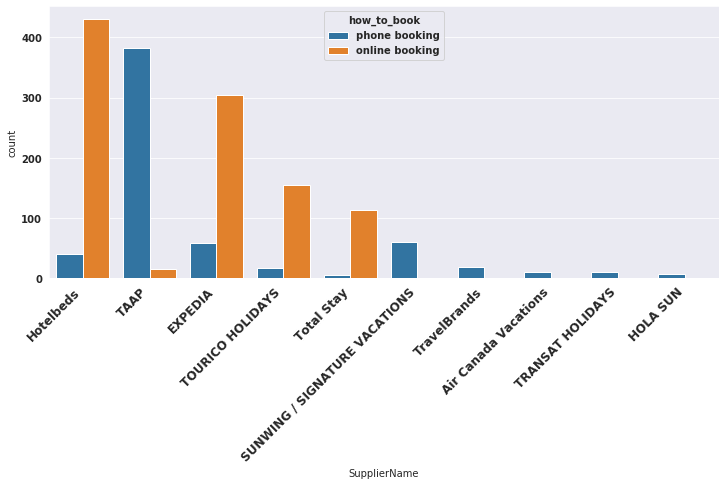

In [74]:
plt.subplots(figsize = (12,5))
sns.countplot(x=df_hotel_no_flight['SupplierName'],order=df_hotel_no_flight['SupplierName'].value_counts()[:10].index,hue=df_hotel_no_flight['how_to_book'])
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
plt.show();

When customers book hotel rooms that supplied by Hotelbeds, Expedia, Tourico or Total Stay, they mostly book online on PC website. However, when customers book hotel rooms that supplied by TAAP or Sunwing/Signature, they mostly book by phone.

## Vacation Hotel Records
This query fetches hotel records that are a part of a vacation package.

Note that the TotalBuy column returns the price of the entire package not just the hotel component.

In [75]:
package_hotel_query = """
    select
        h.FOLDERNO,
        h.SUPPNAME,
        h.BookingDate,
        f.ARRIVALPT,
        f.NOOFPASS,
        h.ROOMS,
        h.HOTELNAME,        
        h.TYPE,
        h.DATEIN,
        h.DATEOUT,
        f.TotalBUY,
        f.BOOKEDBY
    from dbo.FolderMaster f
    JOIN dbo.AirSegDetails a ON f.FOLDERNO = a.FOLDERNO AND a.SLNO = 1
    JOIN dbo.HotelDetails h ON f.FOLDERNO = h.FOLDERNO and h.SLNO = 1
    join dbo.PassengerMaster p on f.FOLDERNO = p.FOLDERNO and p.SLNO = 1
    where
        CUSTOMERNAME = 'PC Travel'
        AND CURCODE = 'CAD'
        and f.STATUS in (1,2)
        and TOTALBuy > 0 
        and lower(p.EMail) not like '%sandhurstconsulting.com'
        and lower(p.EMail) not like '%travelnationcanada.com'
        and lower(p.EMail) not like '%travelnation.com'
        and lower(p.EMail) not like '%pctravel.ca'
        and len(p.Email) > 0
        and len(ARRIVALPT) = 3
        and ISNUMERIC(ARRIVALPT) = 0
"""

In [76]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
with conn.cursor() as cur:
    cur.execute(package_hotel_query)
    results = cur.fetchall()
conn.close()

In [77]:
columns =[
    'FolderNo',
    'SupplierName',
    'BookingDate',
    'Destination',
    'NumPax',
    'NumRooms',
    'HotelName',
    'RoomType',
    'CheckIn',
    'CheckOut',
    'Total',
    'BookedBy',
]
df_hotel_vacation = pd.DataFrame.from_records(results, columns=columns)

In [78]:
df_hotel_vacation.head(2)

FolderNo                  SupplierName BookingDate Destination  NumPax  \
0    10066  Air Canada Vacations/Cruises  2018-09-10         CUN       2   
1    10085              TRANSAT HOLIDAYS  2018-09-11         PUJ       2   

   NumRooms                         HotelName  \
0         1            OCEAN RIVIERA PARADISE   
1         1  LUXURY BAHIA PRINCIPE AMBAR BLUE   

                                            RoomType    CheckIn   CheckOut  \
0  JR SUITE DAISY SUPER SAVER ALL INCLUSIVE, DOUB... 2018-09-14 2018-09-21   
1                                    JR SUITE DELUXE 2018-12-20 2018-12-27   

       Total    BookedBy  
0  1493.5600   PC Travel  
1  4257.9400  smontesano

Remove duplicate FolderNo.

In [79]:
print('duplicate FolderNo: {}'.format(df_hotel_vacation['FolderNo'].duplicated().sum()))

duplicate FolderNo: 96


In [80]:
df_hotel_vacation.drop_duplicates(subset ='FolderNo', keep = 'last', inplace = True)

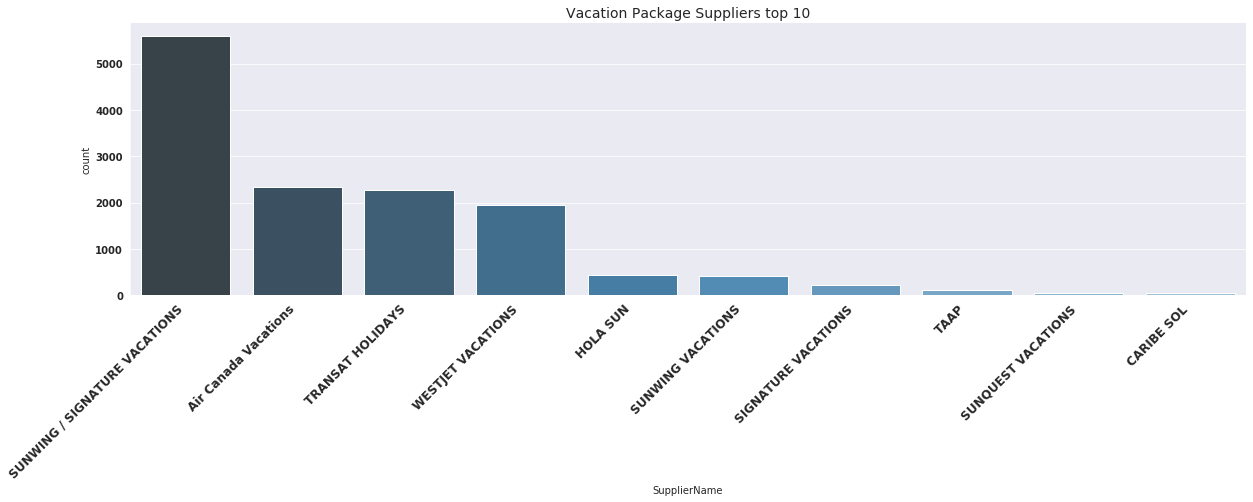

In [85]:
df_hotel_vacation = pd.merge(df_hotel_vacation, df_vacation_flight[['FolderNo', 'AirlineName']], how='left', on='FolderNo')
df_hotel_vacation.drop_duplicates(subset ='FolderNo', keep = 'last', inplace = True)

plt.figure(figsize=(20,5))
sns.countplot(x='SupplierName', data=df_hotel_vacation, order=df_hotel_vacation['SupplierName'].value_counts()[:10].index, palette="Blues_d")
plt.title('Vacation Package Suppliers top 10', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

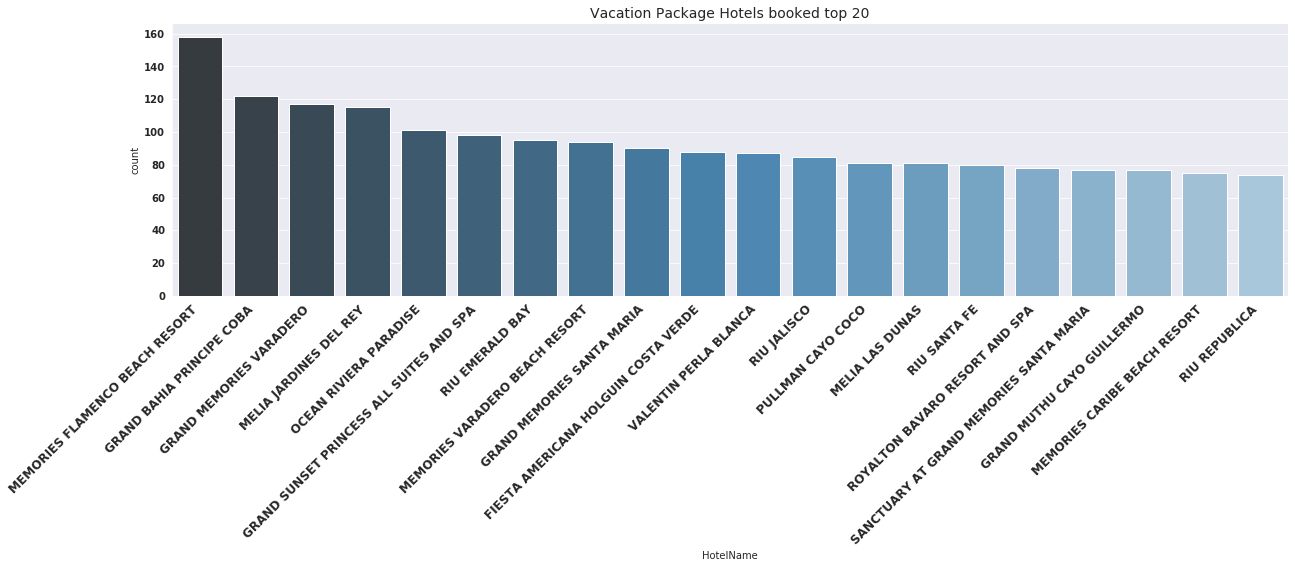

In [86]:
plt.figure(figsize=(20,5))
sns.countplot(x='HotelName', data=df_hotel_vacation, order=df_hotel_vacation['HotelName'].value_counts()[:20].index, palette="Blues_d")
plt.title('Vacation Package Hotels booked top 20', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

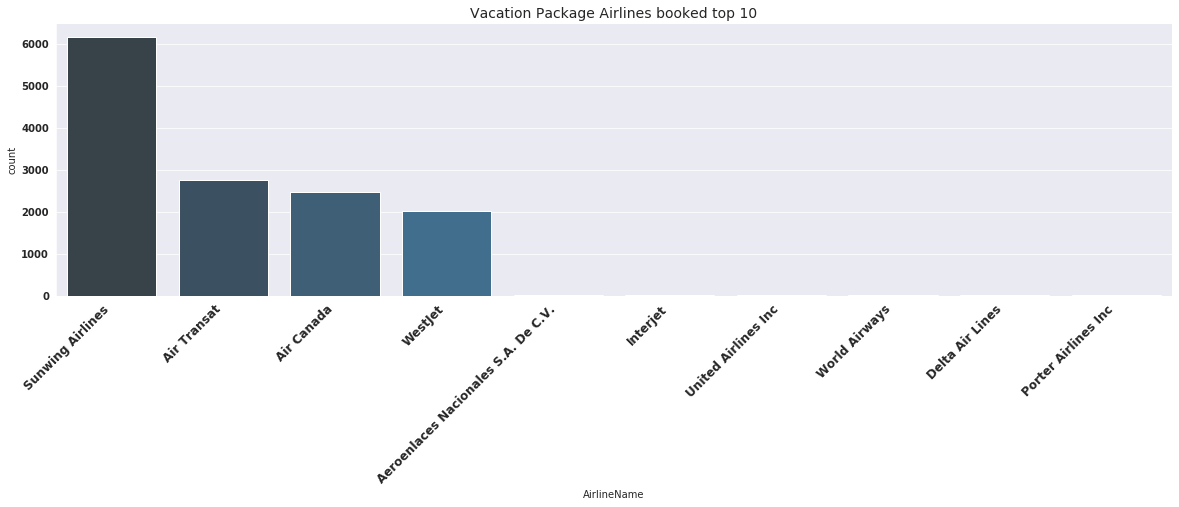

In [87]:
df_hotel_vacation['AirlineName'] = df_hotel_vacation['AirlineName'].replace(r'^\s*$', np.nan, regex=True)

plt.figure(figsize=(20,5))
sns.countplot(x='AirlineName', data=df_hotel_vacation, order=df_hotel_vacation['AirlineName'].value_counts()[:10].index, palette="Blues_d")
plt.title('Vacation Package Airlines booked top 10', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

In [88]:
df_hotel_vacation = pd.merge(df_hotel_vacation, airports_df[['iso_country', 'municipality', 'iata_code']], how='left', left_on='Destination', right_on='iata_code').drop(columns = ['iata_code'])
df_hotel_vacation = df_hotel_vacation.rename(columns={'iso_country': 'destination_country', 'municipality': 'destination_city'})

df_hotel_vacation.drop_duplicates(subset ='FolderNo', keep = 'last', inplace = True)

In [98]:
country_euro = df_hotel_vacation.loc[(df_hotel_vacation['destination_country'] == 'IT') | (df_hotel_vacation['destination_country'] == 'GB') | (df_hotel_vacation['destination_country'] == 'FR') | (df_hotel_vacation['destination_country'] == 'ES') | (df_hotel_vacation['destination_country'] == 'PT') | (df_hotel_vacation['destination_country'] == 'PL')]

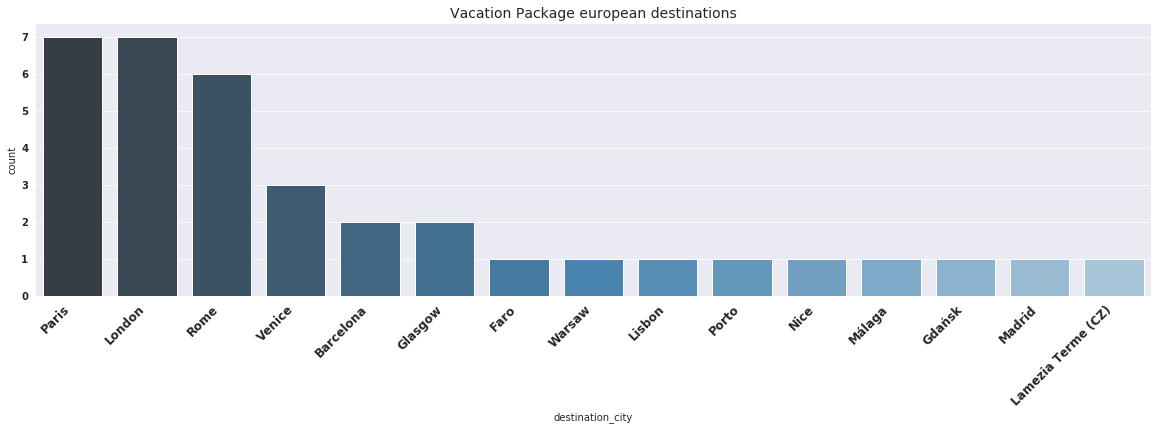

In [100]:
plt.figure(figsize=(20,5))
sns.countplot(x='destination_city', data=country_euro, order=country_euro['destination_city'].value_counts().index, palette="Blues_d")
plt.title('Vacation Package european destinations', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

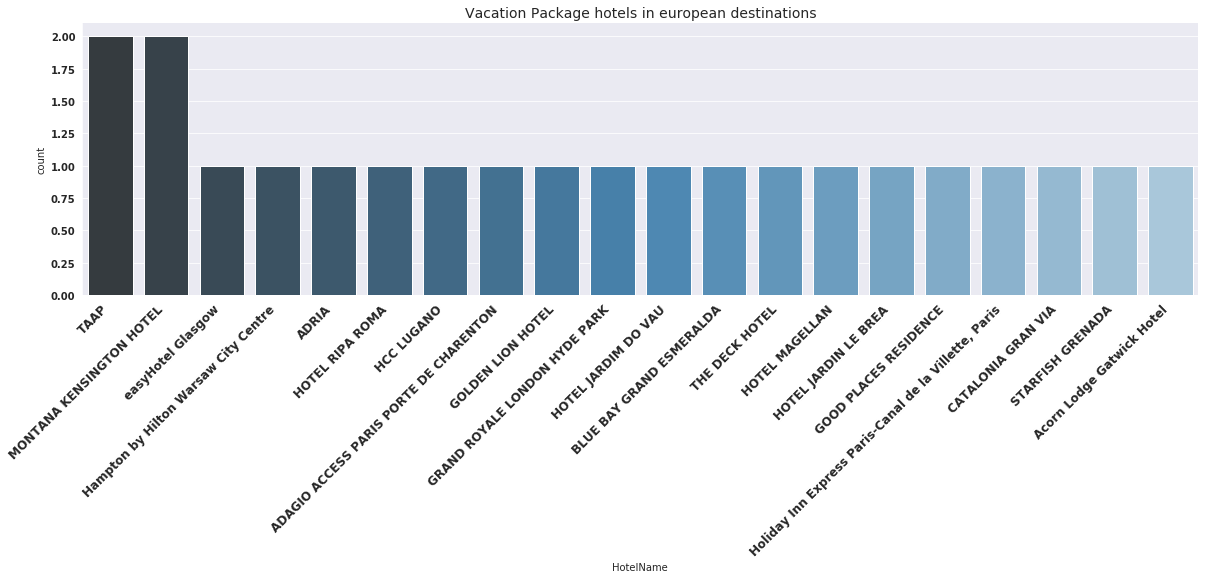

In [105]:
plt.figure(figsize=(20,5))
sns.countplot(x='HotelName', data=country_euro, order=country_euro['HotelName'].value_counts()[:20].index, palette="Blues_d")
plt.title('Vacation Package hotels in european destinations', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

In [110]:
country_euro['booking_window'] = (country_euro['CheckIn'] - country_euro['BookingDate']).dt.days
country_euro['length_of_stay'] = (country_euro['CheckOut'] - country_euro['CheckIn']).dt.days

country_euro = country_euro[country_euro.booking_window >= 0]
country_euro = country_euro[country_euro.length_of_stay > 0]

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
country_euro['checkin_quarter'] = country_euro['CheckIn'].dt.quarter
country_euro['checkin_year'] = country_euro['CheckIn'].dt.year
country_euro["Total"] = country_euro.Total.astype(float)

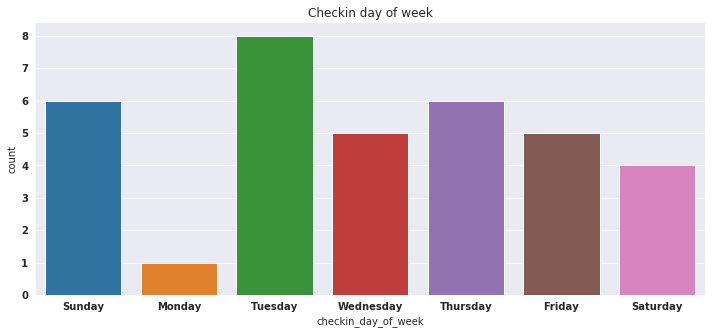

In [127]:
country_euro['checkin_day_of_week'] = country_euro['CheckIn'].dt.day_name()
plt.figure(figsize=(12,5))
sns.countplot(x='checkin_day_of_week', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data = country_euro)
plt.title('Checkin day of week', size=12)
sns.despine();

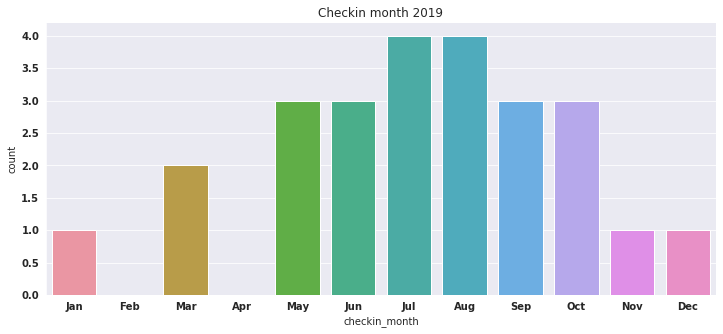

In [217]:
country_euro['checkin_month'] = country_euro['CheckIn'].dt.strftime('%b')

plt.figure(figsize=(12,5))
sns.countplot(x='checkin_month', order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], data = country_euro.loc[country_euro['checkin_year'] == 2019])
plt.title('Checkin month 2019', size=12)
sns.despine();

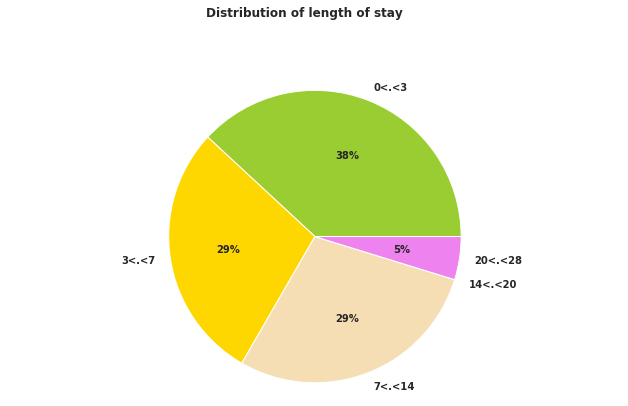

In [224]:
stay_range = [0, 3, 7, 14, 20, 28]
count_stay = []
for i, stay in enumerate(stay_range):
    if i == 0: continue
    val = country_euro[(country_euro['length_of_stay'] < stay) &
                       (country_euro['length_of_stay'] > stay_range[i-1])]['length_of_stay'].count()
    count_stay.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(stay_range[i-1], s) for i,s in enumerate(stay_range) if i != 0]
sizes  = count_stay
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of length of stay", ha='center', fontsize = 12);

In [222]:
country_euro.length_of_stay.describe()

count    35.000000
mean      6.885714
std       5.804519
min       1.000000
25%       3.000000
50%       7.000000
75%       8.500000
max      28.000000
Name: length_of_stay, dtype: float64

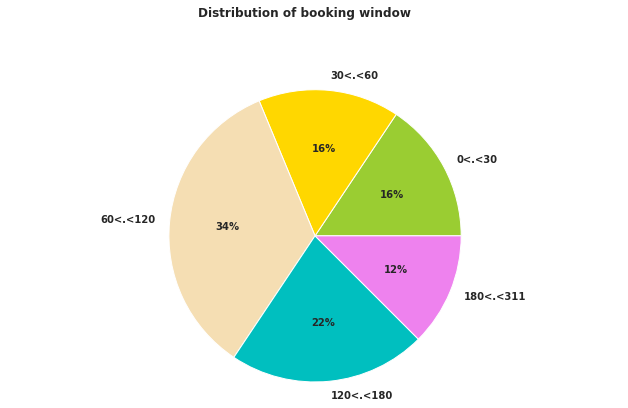

In [231]:
booking_window_range = [0, 30, 60, 120, 180, 311]
count_booking_window = []
for i, booking_window in enumerate(booking_window_range):
    if i == 0: continue
    val = country_euro[(country_euro['booking_window'] < booking_window) &
                       (country_euro['booking_window'] > booking_window_range[i-1])]['booking_window'].count()
    count_booking_window.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(booking_window_range[i-1], s) for i,s in enumerate(booking_window_range) if i != 0]
sizes  = count_booking_window
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of booking window", ha='center', fontsize = 12);

In [229]:
country_euro['booking_window'].describe()

count     35.000000
mean     107.571429
std       80.272069
min        1.000000
25%       47.000000
50%       88.000000
75%      156.500000
max      311.000000
Name: booking_window, dtype: float64

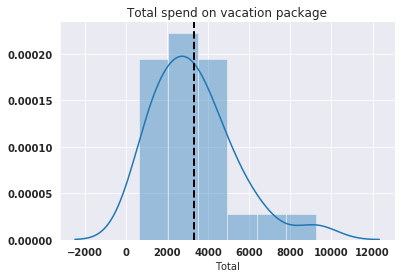

In [218]:
sns.distplot(country_euro.loc[country_euro['checkin_year'] == 2019]['Total'])
plt.axvline(country_euro.loc[country_euro['checkin_year'] == 2019]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package')
#plt.xlim(0,10000)
sns.despine();

In [219]:
country_euro.loc[country_euro['checkin_year'] == 2019]['Total'].describe()

count      25.000000
mean     3297.497600
std      1991.787941
min       613.000000
25%      1738.620000
50%      3172.820000
75%      4240.800000
max      9230.070000
Name: Total, dtype: float64

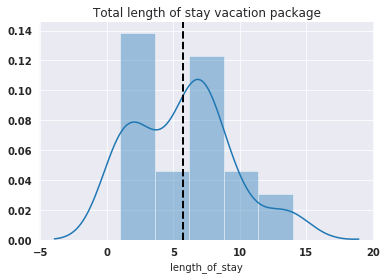

In [144]:
sns.distplot(country_euro.loc[country_euro['checkin_year'] == 2019]['length_of_stay'])
plt.axvline(country_euro.loc[country_euro['checkin_year'] == 2019]['length_of_stay'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total length of stay vacation package')
# plt.xlim(0,10000)
sns.despine();

In [145]:
country_euro.loc[country_euro['checkin_year'] == 2019]['length_of_stay'].describe()

count    25.000000
mean      5.720000
std       3.668787
min       1.000000
25%       3.000000
50%       7.000000
75%       7.000000
max      14.000000
Name: length_of_stay, dtype: float64

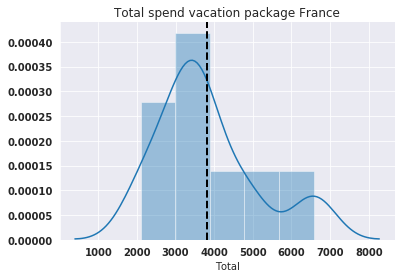

In [165]:
sns.distplot(country_euro.loc[country_euro['destination_country'] == 'FR']['Total'])
plt.axvline(country_euro.loc[country_euro['destination_country'] == 'FR']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend vacation package France')
# plt.xlim(0,10000)
sns.despine();

In [166]:
country_euro.loc[country_euro['destination_country'] == 'FR']['Total'].describe()

count       8.000000
mean     3810.560000
std      1379.157362
min      2094.420000
25%      3071.700000
50%      3544.050000
75%      4165.650000
max      6574.440000
Name: Total, dtype: float64

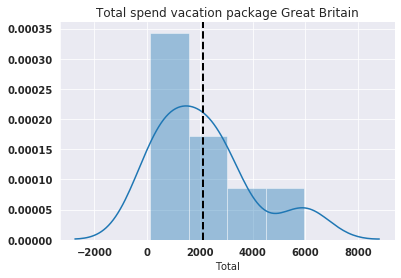

In [232]:
sns.distplot(country_euro.loc[country_euro['destination_country'] == 'GB']['Total'])
plt.axvline(country_euro.loc[country_euro['destination_country'] == 'GB']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend vacation package Great Britain')
#plt.xlim(0,4000)
sns.despine();

In [233]:
country_euro.loc[country_euro['destination_country'] == 'GB']['Total'].describe()

count       8.000000
mean     2119.127500
std      1877.135294
min       120.850000
25%       879.752500
50%      1840.785000
75%      2719.957500
max      5948.880000
Name: Total, dtype: float64

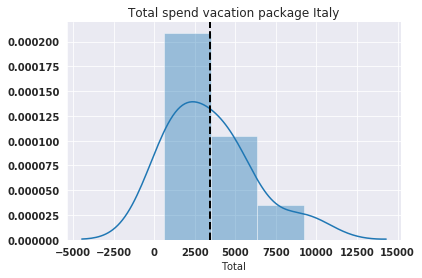

In [234]:
sns.distplot(country_euro.loc[country_euro['destination_country'] == 'IT']['Total'])
plt.axvline(country_euro.loc[country_euro['destination_country'] == 'IT']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend vacation package Italy')
# plt.xlim(0,10000)
sns.despine();

In [235]:
country_euro.loc[country_euro['destination_country'] == 'IT']['Total'].describe()

count      10.000000
mean     3421.735000
std      2626.235542
min       613.000000
25%      1422.292500
50%      2905.480000
75%      4834.710000
max      9230.070000
Name: Total, dtype: float64

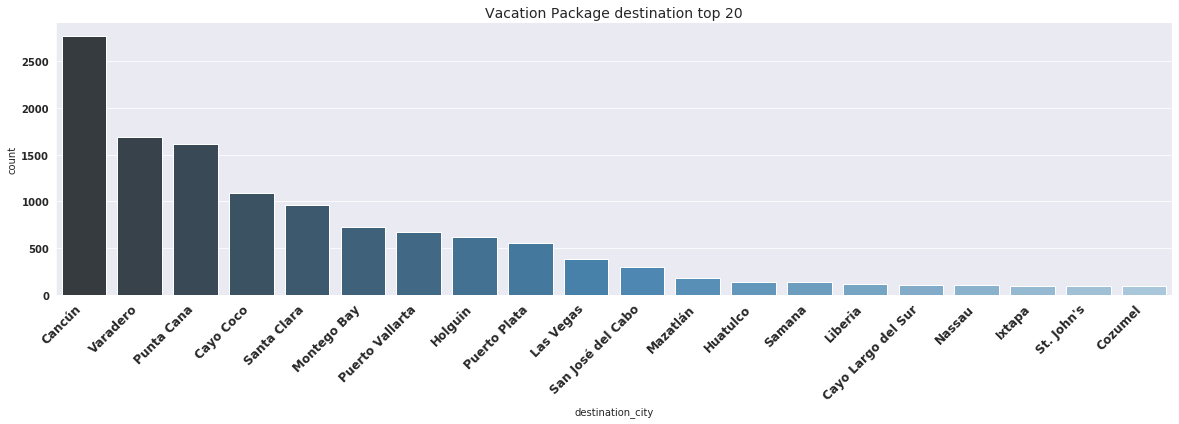

In [113]:
plt.figure(figsize=(20,5))
sns.countplot(x='destination_city', data=df_hotel_vacation, order=df_hotel_vacation['destination_city'].value_counts()[:20].index, palette="Blues_d")
plt.title('Vacation Package destination top 20', size=14)
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
sns.despine();

In [114]:
df_hotel_vacation['booking_window'] = (df_hotel_vacation['CheckIn'] - df_hotel_vacation['BookingDate']).dt.days
df_hotel_vacation['length_of_stay'] = (df_hotel_vacation['CheckOut'] - df_hotel_vacation['CheckIn']).dt.days

df_hotel_vacation = df_hotel_vacation[df_hotel_vacation.booking_window >= 0]
df_hotel_vacation = df_hotel_vacation[df_hotel_vacation.length_of_stay > 0]

In [115]:
print(f' Booking date minimum value {df_hotel_vacation.BookingDate.min()}')
print(f' Booking date maximum value {df_hotel_vacation.BookingDate.max()}')

 Booking date minimum value 2018-01-19 00:00:00
 Booking date maximum value 2020-01-30 00:00:00


In [116]:
print(f' Checkin date minimum value {df_hotel_vacation.CheckIn.min()}')
print(f' Checkin date maximum value {df_hotel_vacation.CheckIn.max()}')

 Checkin date minimum value 2018-09-11 00:00:00
 Checkin date maximum value 2021-04-07 00:00:00


In [117]:
df_hotel_vacation.head(2)

FolderNo                  SupplierName BookingDate Destination  NumPax  \
0    10066  Air Canada Vacations/Cruises  2018-09-10         CUN       2   
1    10085              TRANSAT HOLIDAYS  2018-09-11         PUJ       2   

   NumRooms                         HotelName  \
0         1            OCEAN RIVIERA PARADISE   
1         1  LUXURY BAHIA PRINCIPE AMBAR BLUE   

                                            RoomType    CheckIn   CheckOut  \
0  JR SUITE DAISY SUPER SAVER ALL INCLUSIVE, DOUB... 2018-09-14 2018-09-21   
1                                    JR SUITE DELUXE 2018-12-20 2018-12-27   

       Total    BookedBy  AirlineName destination_country destination_city  \
0  1493.5600   PC Travel   Air Canada                  MX           Cancún   
1  4257.9400  smontesano  Air Transat                  DO       Punta Cana   

   booking_window  length_of_stay  
0               4               7  
1             100               7

In [118]:
df_booking = df_hotel_vacation.BookingDate.value_counts().reset_index()
df_booking = df_booking.rename(columns={'index': 'booking_date', 'BookingDate': 'count'})
df_booking = df_booking.sort_values(by='booking_date')

fig = px.line(df_booking, x='booking_date', y='count')
fig.update_layout(title_text="Booking date time series")
fig.show()

Observations: 

* Again, we have a problem here. Booking happened prior to Oct 2018 is problematic. Therefore, for the following analysis when we breakup by month, quarter, we will only use 2019 one year checkin data. 

* PC Travel had a busy day on 2019-01-01, it received 221 bookings on that day.

In [119]:
df_checkin = df_hotel_vacation.CheckIn.value_counts().reset_index()
df_checkin = df_checkin.rename(columns={'index': 'checkin_date', 'CheckIn': 'count'})
df_checkin = df_checkin.sort_values(by='checkin_date')

fig = px.line(df_checkin, x='checkin_date', y='count')
fig.update_layout(title_text="Checkin date time series")
fig.show()

Observations:

* The busiest check in date was 2019-03-10, that was definitely for March break.
* The 2nd busiest check in date was prior to Christmas and after New year.

Check in by day of week, month, quarter

In [120]:
df_hotel_vacation['checkin_quarter'] = df_hotel_vacation['CheckIn'].dt.quarter
df_hotel_vacation['checkin_year'] = df_hotel_vacation['CheckIn'].dt.year
df_hotel_vacation["Total"] = df_hotel_vacation.Total.astype(float)

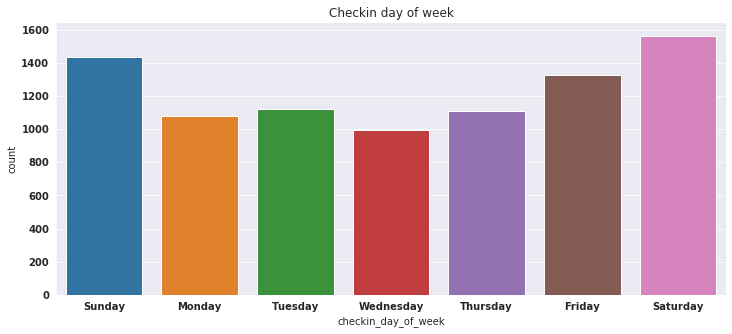

In [121]:
df_hotel_vacation['checkin_day_of_week'] = df_hotel_vacation['CheckIn'].dt.day_name()
plt.figure(figsize=(12,5))
sns.countplot(x='checkin_day_of_week', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data =df_hotel_vacation.loc[df_hotel_vacation['checkin_year'] == 2019])
plt.title('Checkin day of week', size=12)
sns.despine();

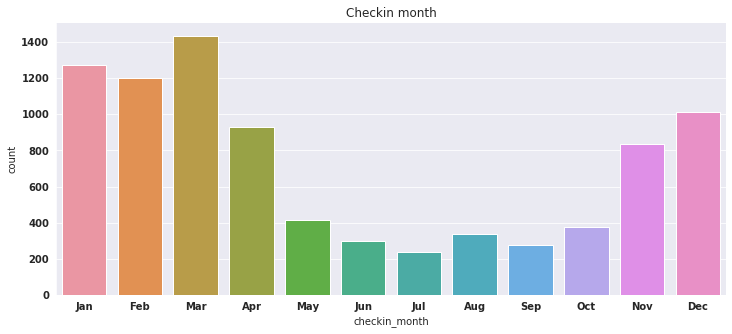

In [122]:
df_hotel_vacation['checkin_month'] = df_hotel_vacation['CheckIn'].dt.strftime('%b')

plt.figure(figsize=(12,5))
sns.countplot(x='checkin_month', order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], data =df_hotel_vacation.loc[df_hotel_vacation['checkin_year'] == 2019])
plt.title('Checkin month', size=12)
sns.despine();

This inline with the above time series line chart, March (March break) is the top travel season, followed by around new year, and Christmas. They are not active in summer (or they book summer vacation elsewhere). This is a bit different with PC Travel customers who book hotels only. If you remember, for customers who book hotel only, their top travel month are Aug and Christmas. This indicats that PC Travel customers who book vacation packages are primarily for warm-weather getaways.  

### Average booking value by qurter.

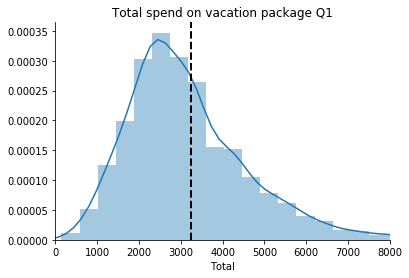

In [41]:
sns.distplot(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 1) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 1) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Q1')
plt.xlim(0,8000)
sns.despine();

In [42]:
df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 1) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].describe()

count     3908.000000
mean      3239.211686
std       1683.350910
min        148.900000
25%       2176.045000
50%       2914.020000
75%       3958.635000
max      21751.440000
Name: Total, dtype: float64

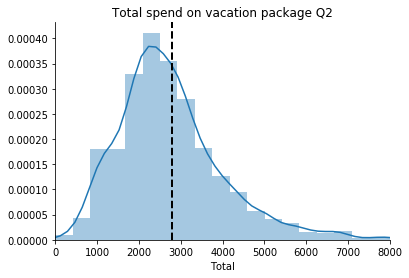

In [43]:
sns.distplot(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 2) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 2) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Q2')
plt.xlim(0, 8000)
sns.despine();

In [44]:
df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 2) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].describe()

count     1651.000000
mean      2796.038831
std       1440.995290
min          3.940000
25%       1925.100000
50%       2566.640000
75%       3358.350000
max      20838.000000
Name: Total, dtype: float64

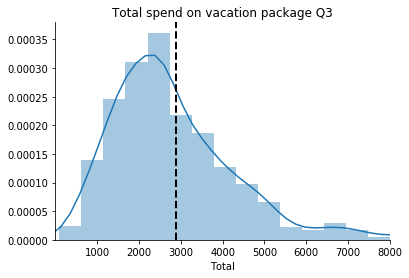

In [45]:
sns.distplot(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 3) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 3) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Q3')
plt.xlim(1, 8000)
sns.despine();

In [46]:
df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 3) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].describe()

count      855.000000
mean      2880.383988
std       1780.662457
min         99.000000
25%       1796.930000
50%       2532.000000
75%       3577.455000
max      26452.700000
Name: Total, dtype: float64

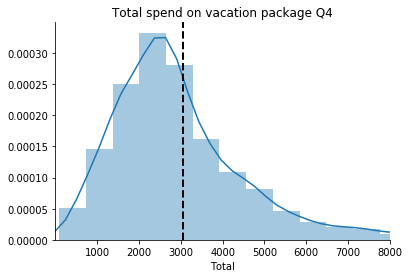

In [47]:
sns.distplot(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 4) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'])
plt.axvline(df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 4) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Q4')
plt.xlim(1, 8000)
sns.despine();

In [48]:
df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 4) & (df_hotel_vacation['checkin_year'] == 2019)]['Total'].describe()

count     2225.000000
mean      3051.774153
std       2000.119556
min        100.000000
25%       1873.560000
50%       2660.500000
75%       3685.420000
max      31986.000000
Name: Total, dtype: float64

Total spending on vacation package bookings by quarter. Customers are most willing to spend in the first quarter of the year, followed by the last quarter of the year.

* First quarter: 3,239 dollars
* Second quarter: 2,796 dollars
* Third quarter: 2,880 dollars
* Fourth quarter: 3,051 dollars

### Top destination cities they travel to in each quarter.

The top destination cities in every quarter are identical.

In [49]:
quarter_1 = df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 1) & (df_hotel_vacation['checkin_year'] == 2019)]['destination_city'].value_counts().reset_index()
quarter_1.rename(columns={'index': 'city', 'destination_city': 'count'}, inplace=True)
quarter_1.head(10)

city  count
0             Cancún    798
1           Varadero    494
2         Punta Cana    428
3          Cayo Coco    299
4        Santa Clara    259
5    Puerto Vallarta    215
6        Montego Bay    187
7            Holguin    183
8       Puerto Plata    162
9  San José del Cabo    102

In [50]:
quarter_2 = df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 2) & (df_hotel_vacation['checkin_year'] == 2019)]['destination_city'].value_counts().reset_index()
quarter_2.rename(columns={'index': 'city', 'destination_city': 'count'}, inplace=True)
quarter_2.head(10)

city  count
0           Cancún    328
1       Punta Cana    203
2         Varadero    180
3        Cayo Coco    132
4      Santa Clara    116
5      Montego Bay    100
6          Holguin     86
7        Las Vegas     72
8     Puerto Plata     67
9  Puerto Vallarta     64

In [51]:
quarter_3 = df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 3) & (df_hotel_vacation['checkin_year'] == 2019)]['destination_city'].value_counts().reset_index()
quarter_3.rename(columns={'index': 'city', 'destination_city': 'count'}, inplace=True)
quarter_3.head(10)

city  count
0       Punta Cana    149
1           Cancún    138
2         Varadero    119
3      Santa Clara     67
4      Montego Bay     59
5        Cayo Coco     57
6        Las Vegas     54
7          Holguin     31
8  Puerto Vallarta     23
9     Puerto Plata     22

In [52]:
quarter_4 = df_hotel_vacation.loc[(df_hotel_vacation['checkin_quarter'] == 4) & (df_hotel_vacation['checkin_year'] == 2019)]['destination_city'].value_counts().reset_index()
quarter_4.rename(columns={'index': 'city', 'destination_city': 'count'}, inplace=True)
quarter_4.head(10)

city  count
0           Cancún    496
1       Punta Cana    281
2         Varadero    277
3        Cayo Coco    185
4      Santa Clara    160
5      Montego Bay    127
6          Holguin    118
7  Puerto Vallarta    111
8     Puerto Plata     82
9        Las Vegas     66

### Top hotels they stay in each Top destination cities for the entire time period.

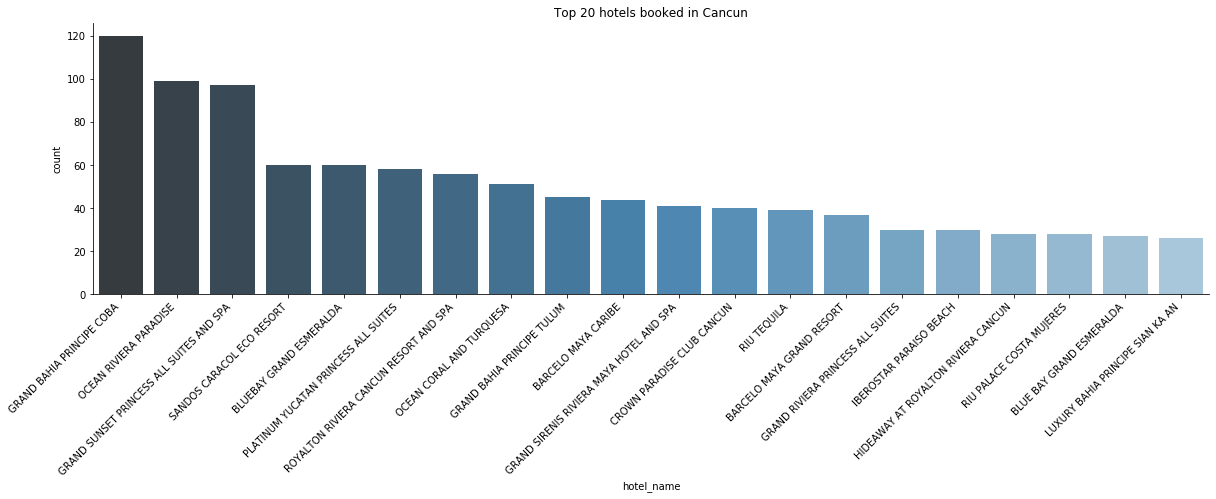

In [53]:
cancun_hotel = df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cancún']['HotelName'].value_counts().reset_index()
cancun_hotel.rename(columns={'index': 'hotel_name', 'HotelName': 'count'}, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x="hotel_name", y="count", data=cancun_hotel.head(20), palette="Blues_d")
plt.title('Top 20 hotels booked in Cancun')
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine();

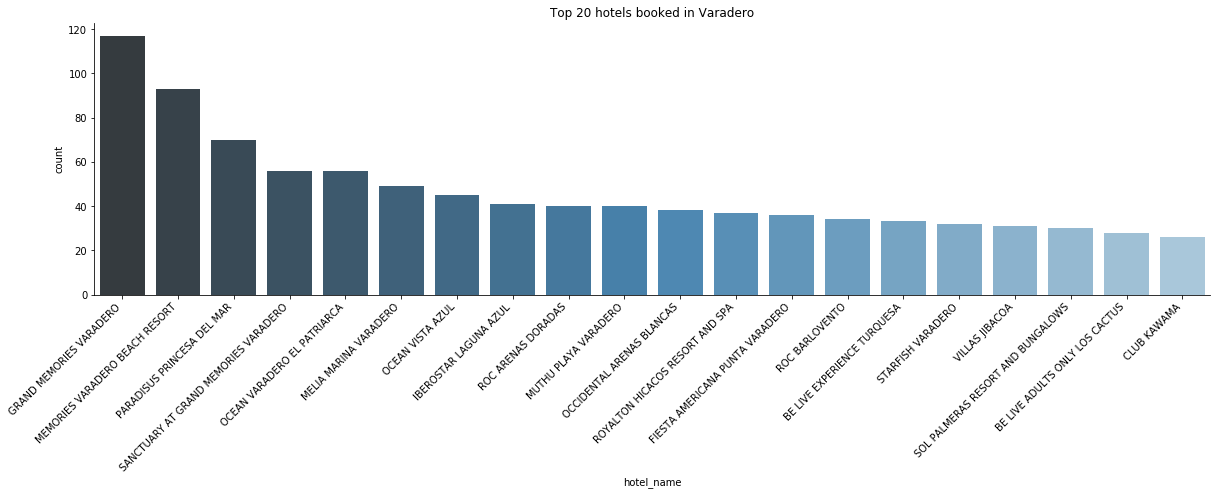

In [54]:
varadero_hotel = df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Varadero']['HotelName'].value_counts().reset_index()
varadero_hotel.rename(columns={'index': 'hotel_name', 'HotelName': 'count'}, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x="hotel_name", y="count", data=varadero_hotel.head(20), palette="Blues_d")
plt.title('Top 20 hotels booked in Varadero')
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine();

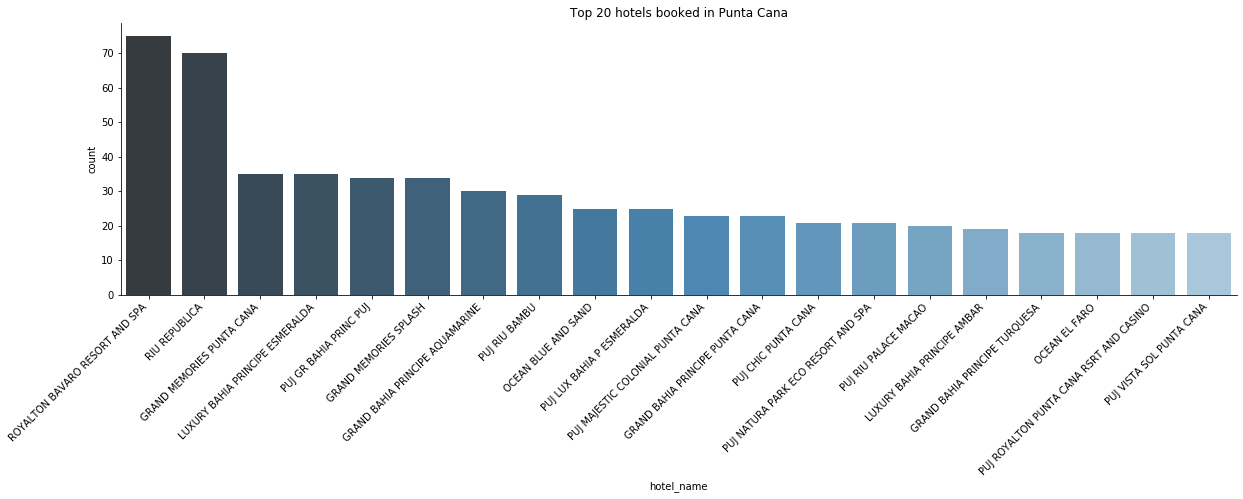

In [55]:
punta_cana_hotel = df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Punta Cana']['HotelName'].value_counts().reset_index()
punta_cana_hotel.rename(columns={'index': 'hotel_name', 'HotelName': 'count'}, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x="hotel_name", y="count", data=punta_cana_hotel.head(20), palette="Blues_d")
plt.title('Top 20 hotels booked in Punta Cana')
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine();

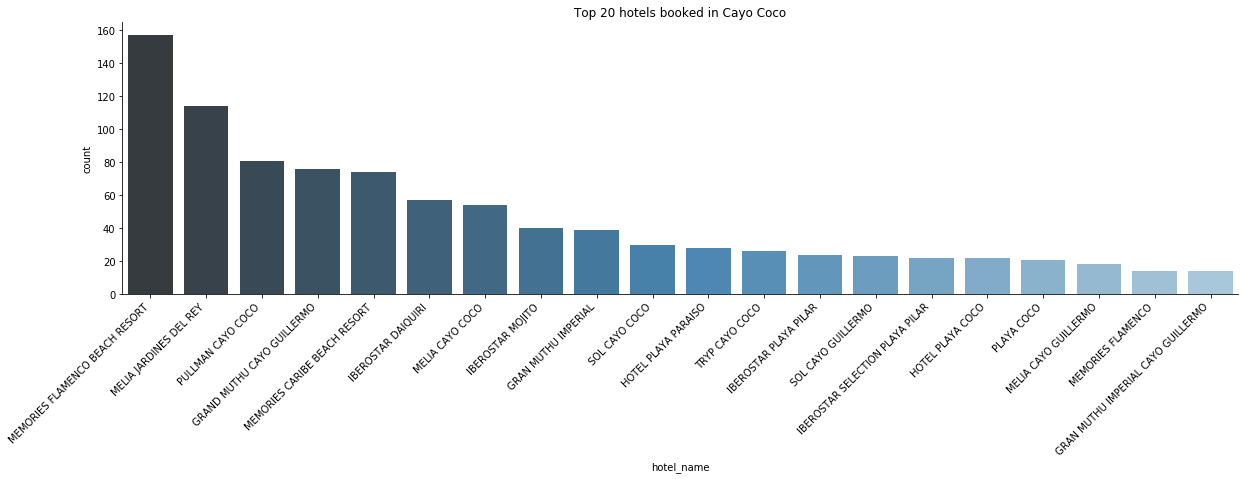

In [56]:
cayo_coco_hotel = df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cayo Coco']['HotelName'].value_counts().reset_index()
cayo_coco_hotel.rename(columns={'index': 'hotel_name', 'HotelName': 'count'}, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x="hotel_name", y="count", data=cayo_coco_hotel.head(20), palette="Blues_d")
plt.title('Top 20 hotels booked in Cayo Coco')
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine();

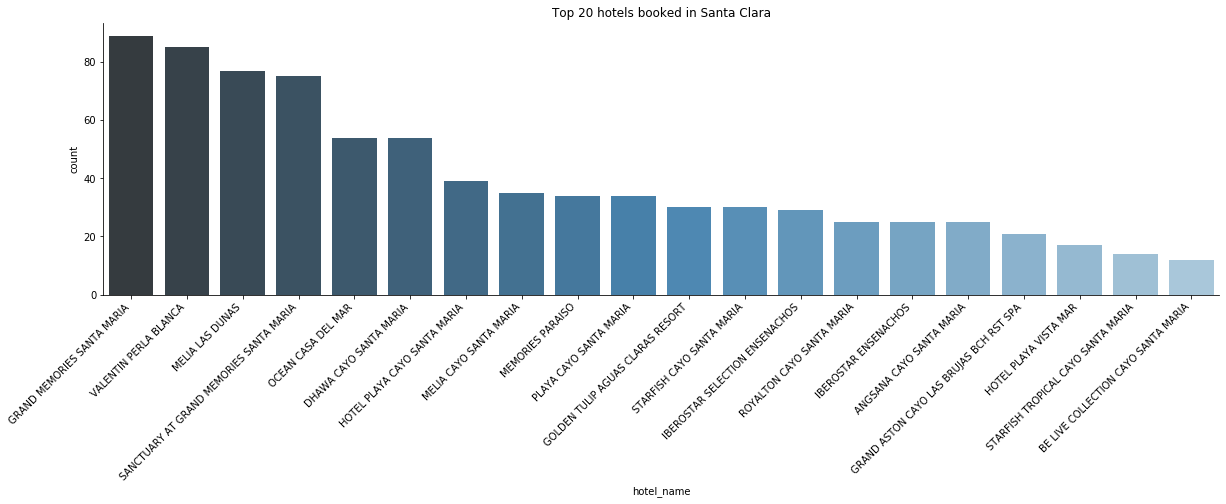

In [57]:
santa_clara_hotel = df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Santa Clara']['HotelName'].value_counts().reset_index()
santa_clara_hotel.rename(columns={'index': 'hotel_name', 'HotelName': 'count'}, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x="hotel_name", y="count", data=santa_clara_hotel.head(20), palette="Blues_d")
plt.title('Top 20 hotels booked in Santa Clara')
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine();

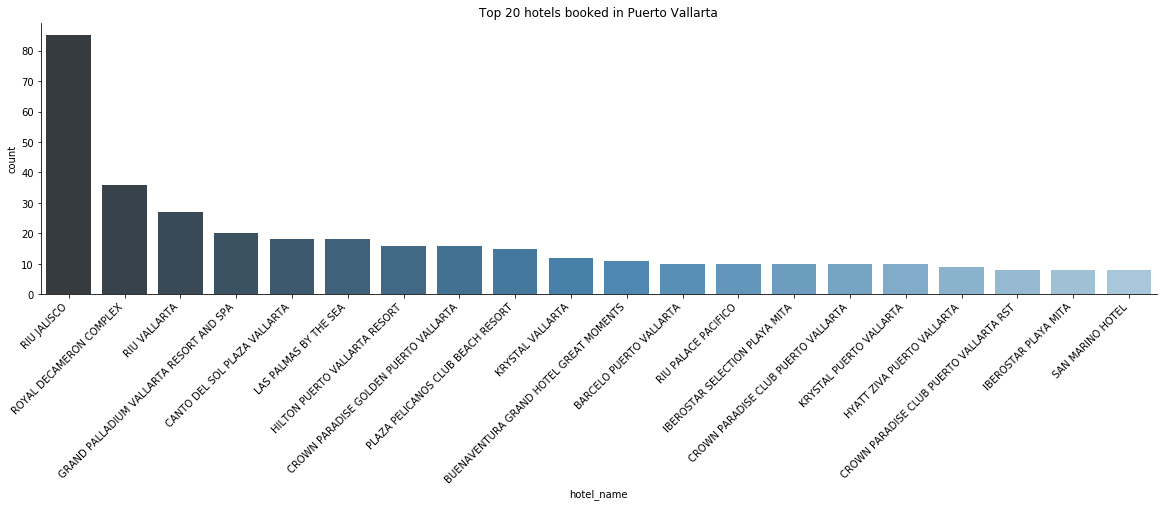

In [58]:
puerto_vallarta_hotel = df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Puerto Vallarta']['HotelName'].value_counts().reset_index()
puerto_vallarta_hotel.rename(columns={'index': 'hotel_name', 'HotelName': 'count'}, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x="hotel_name", y="count", data=puerto_vallarta_hotel.head(20), palette="Blues_d")
plt.title('Top 20 hotels booked in Puerto Vallarta')
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine();

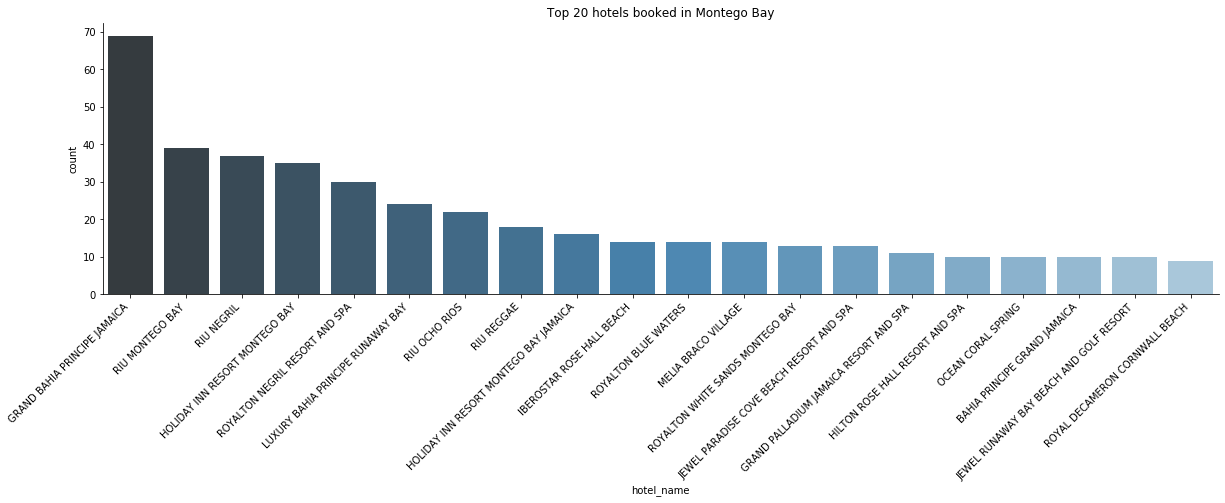

In [59]:
montego_bay_hotel = df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Montego Bay']['HotelName'].value_counts().reset_index()
montego_bay_hotel.rename(columns={'index': 'hotel_name', 'HotelName': 'count'}, inplace=True)
plt.figure(figsize=(20,5))
sns.barplot(x="hotel_name", y="count", data=montego_bay_hotel.head(20), palette="Blues_d")
plt.title('Top 20 hotels booked in Montego Bay')
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine();

#### Vacation spending by destination cities.

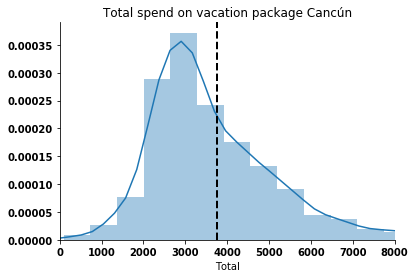

In [91]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cancún']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cancún']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Cancún')
plt.xlim(0, 8000)
sns.despine();

In [92]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cancún']['Total'].describe()

count     2702.000000
mean      3769.025614
std       1853.582046
min         93.310000
25%       2632.300000
50%       3300.010000
75%       4501.770000
max      31986.000000
Name: Total, dtype: float64

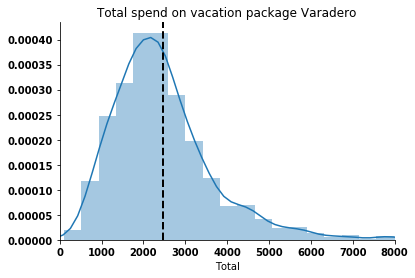

In [93]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Varadero']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Varadero']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Varadero')
plt.xlim(0, 8000)
sns.despine();

In [94]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Varadero']['Total'].describe()

count     1655.000000
mean      2475.547547
std       1322.578839
min         99.000000
25%       1646.345000
50%       2276.650000
75%       2987.225000
max      20838.000000
Name: Total, dtype: float64

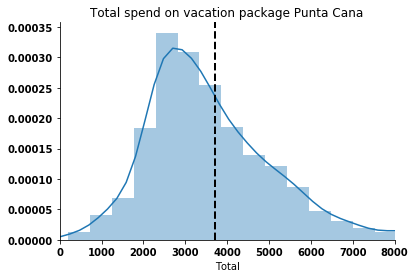

In [95]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Punta Cana']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Punta Cana']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Punta Cana')
plt.xlim(0, 8000)
sns.despine();

In [96]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Punta Cana']['Total'].describe()

count     1566.000000
mean      3716.090683
std       1846.031629
min        200.000000
25%       2537.000000
50%       3337.900000
75%       4501.337500
max      26368.100000
Name: Total, dtype: float64

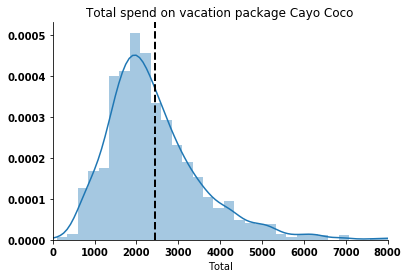

In [97]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cayo Coco']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cayo Coco']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Cayo Coco')
plt.xlim(0,8000)
sns.despine();

In [98]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Cayo Coco']['Total'].describe()

count    1072.000000
mean     2441.638125
std      1189.978513
min       100.000000
25%      1667.500000
50%      2215.985000
75%      2944.340000
max      9076.850000
Name: Total, dtype: float64

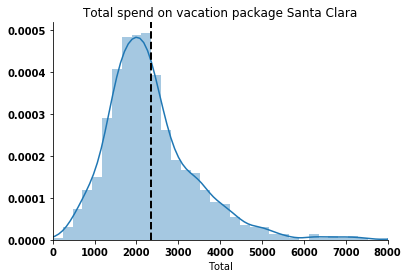

In [101]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Santa Clara']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Santa Clara']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Santa Clara')
plt.xlim(0,8000)
sns.despine();

In [102]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Santa Clara']['Total'].describe()

count      938.000000
mean      2352.311855
std       1111.030155
min          3.940000
25%       1647.990000
50%       2164.300000
75%       2803.597500
max      10350.000000
Name: Total, dtype: float64

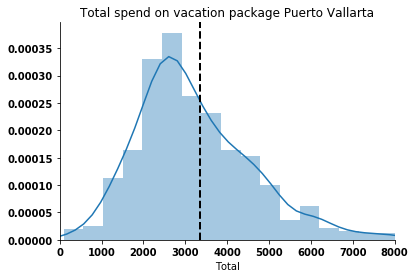

In [103]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Puerto Vallarta']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Puerto Vallarta']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Puerto Vallarta')
plt.xlim(0,8000)
sns.despine();

In [104]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Puerto Vallarta']['Total'].describe()

count      663.000000
mean      3347.843635
std       1917.988667
min         91.000000
25%       2304.040000
50%       2955.900000
75%       4084.470000
max      23614.680000
Name: Total, dtype: float64

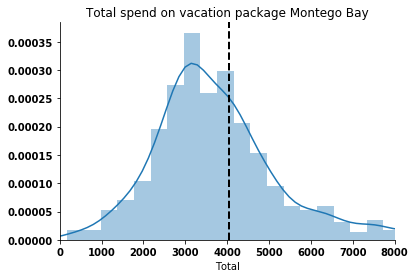

In [105]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Montego Bay']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Montego Bay']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Montego Bay')
plt.xlim(0,8000)
sns.despine();

In [106]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Montego Bay']['Total'].describe()

count      708.000000
mean      4039.623686
std       2116.130614
min        182.000000
25%       2817.230000
50%       3558.150000
75%       4605.815000
max      16482.100000
Name: Total, dtype: float64

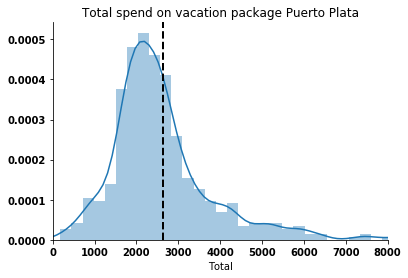

In [107]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Puerto Plata']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Puerto Plata']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Puerto Plata')
plt.xlim(0,8000)
sns.despine();

In [108]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Puerto Plata']['Total'].describe()

count      540.00000
mean      2634.87663
std       1352.00225
min        182.00000
25%       1877.91250
50%       2362.21000
75%       2978.82500
max      12649.68000
Name: Total, dtype: float64

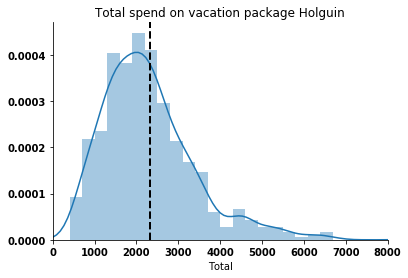

In [109]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Holguin']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Holguin']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package Holguin')
plt.xlim(0,8000)
sns.despine();

In [110]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'Holguin']['Total'].describe()

count     610.000000
mean     2318.633361
std      1196.212903
min       405.990000
25%      1520.845000
50%      2130.260000
75%      2818.680000
max      9993.580000
Name: Total, dtype: float64

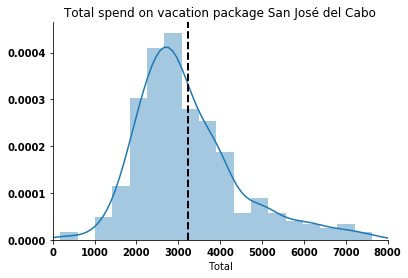

In [111]:
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'San José del Cabo']['Total'])
plt.axvline(df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'San José del Cabo']['Total'].mean(),linewidth=2 ,linestyle = "dashed",color = "k",label = "Mean")
plt.title('Total spend on vacation package San José del Cabo')
plt.xlim(0,8000)
sns.despine();

In [112]:
df_hotel_vacation.loc[df_hotel_vacation['destination_city'] == 'San José del Cabo']['Total'].describe()

count      295.000000
mean      3240.032508
std       1305.526950
min        184.700000
25%       2430.270000
50%       2930.040000
75%       3809.910000
max      10528.100000
Name: Total, dtype: float64

The average total spending for vacation packages by top 10 destination cities as follows:

* Cancun: 3778 dollars
* Varadero: 2476 dollars
* Punta Cana: 3720 dollars
* Cayo Coco: 2450 dollars
* Santa Clara: 2354 dollars
* Puerto Vallarta: 3362 dollars
* Montego Bay: 4057 dollars
* Puerto Plata: 2642 dollars
* Holguin: 2317 dollars
* San José del Cabo: 3237 dollars

Now we have some ideas on where is the most / least expensive destinations.

The main reason the customers stay at these hotels is that they booked Sunwing or Signature or Transat vacation packages and these hotels are in the packages. If we want the cutomers to say at our recommended hotels, then we have a bigger problem to cope.  

In [80]:
df_hotel_vacation[['Total', 'booking_window', 'length_of_stay', 'NumPax']].describe().T

count         mean          std   min      25%     50%  \
Total           13353.0  3118.484660  1785.206689  3.94  2020.56  2759.8   
booking_window  13353.0    57.842283    52.072488  0.00    20.00    43.0   
length_of_stay  13353.0     7.406201     3.940890  1.00     7.00     7.0   
NumPax          13353.0     2.416461     1.052582  1.00     2.00     2.0   

                   75%      max  
Total           3828.3  31986.0  
booking_window    79.0    674.0  
length_of_stay     7.0    373.0  
NumPax             3.0     18.0

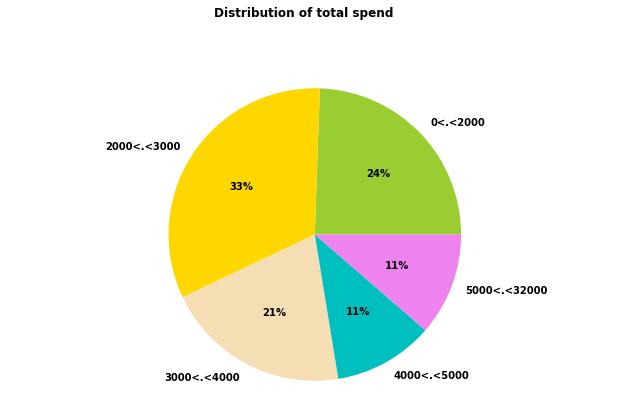

In [81]:
total_range = [0, 2000, 3000, 4000, 5000, 32000]
count_total = []
for i, total in enumerate(total_range):
    if i == 0: continue
    val = df_hotel_vacation[(df_hotel_vacation['Total'] < total) &
                       (df_hotel_vacation['Total'] > total_range[i-1])]['Total'].count()
    count_total.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(total_range[i-1], s) for i,s in enumerate(total_range) if i != 0]
sizes  = count_total
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of total spend", ha='center', fontsize = 12);

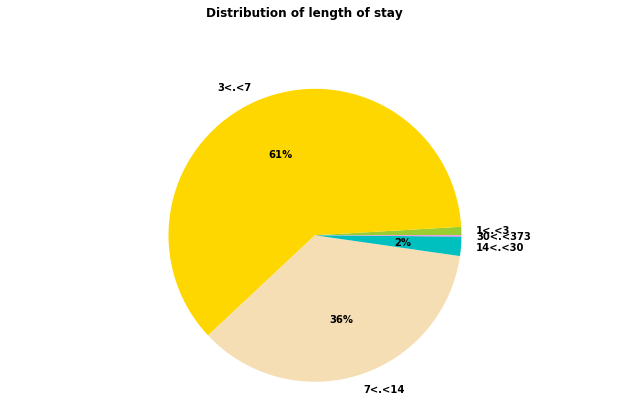

In [82]:
length_range = [1, 3, 7, 14, 30, 373]
count_length = []
for i, length in enumerate(length_range):
    if i == 0: continue
    val = df_hotel_vacation[(df_hotel_vacation['length_of_stay'] < length) &
                       (df_hotel_vacation['length_of_stay'] > length_range[i-1])]['length_of_stay'].count()
    count_length.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(length_range[i-1], s) for i,s in enumerate(length_range) if i != 0]
sizes  = count_length
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of length of stay", ha='center', fontsize = 12);

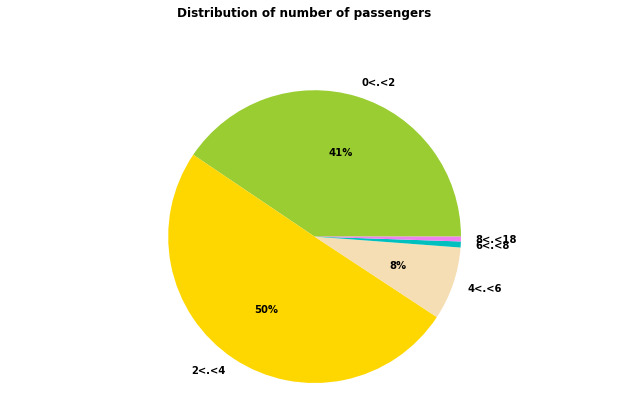

In [83]:
numpax_range = [0,2,4,6,8,18]
count_numpax = []
for i, numpax in enumerate(numpax_range):
    if i == 0: continue
    val = df_hotel_vacation[(df_hotel_vacation['NumPax'] < numpax) &
                       (df_hotel_vacation['NumPax'] > numpax_range[i-1])]['NumPax'].count()
    count_numpax.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'green']
labels = [ '{}<.<{}'.format(numpax_range[i-1], s) for i,s in enumerate(numpax_range) if i != 0]
sizes  = count_numpax
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of number of passengers", ha='center', fontsize = 12);

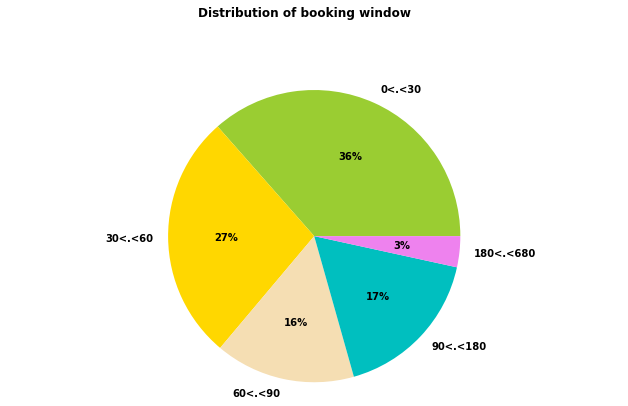

In [84]:
booking_window_range = [0, 30, 60, 90, 180, 680]
count_booking_window = []
for i, booking_window in enumerate(booking_window_range):
    if i == 0: continue
    val = df_hotel_vacation[(df_hotel_vacation['booking_window'] < booking_window) &
                       (df_hotel_vacation['booking_window'] > booking_window_range[i-1])]['booking_window'].count()
    count_booking_window.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet']
labels = [ '{}<.<{}'.format(booking_window_range[i-1], s) for i,s in enumerate(booking_window_range) if i != 0]
sizes  = count_booking_window
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of booking window", ha='center', fontsize = 12);

In [85]:
df_hotel_vacation = df_hotel_vacation[df_hotel_vacation.BookedBy != 'Online']
df_hotel_vacation.loc[df_hotel_vacation['BookedBy'] == 'PC Travel', 'how_to_book'] = 'online booking'
df_hotel_vacation.loc[df_hotel_vacation['BookedBy'] != 'PC Travel', 'how_to_book'] = 'phone booking'

In [86]:
df_hotel_vacation.how_to_book.value_counts() / df_hotel_vacation.shape[0]

phone booking     0.50357
online booking    0.49643
Name: how_to_book, dtype: float64

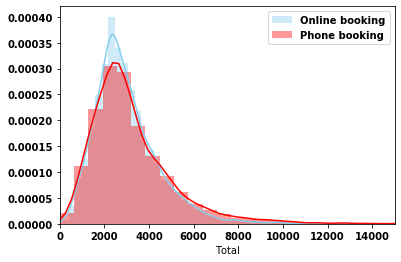

In [87]:
sns.distplot(df_hotel_vacation[df_hotel_vacation["how_to_book"] == 'online booking']['Total'] , color="skyblue", label="Online booking")
sns.distplot(df_hotel_vacation.loc[df_hotel_vacation["how_to_book"] == 'phone booking']['Total'] , color="red", label="Phone booking")
plt.xlim(0, 15000)
plt.legend();

In [88]:
df_hotel_vacation[df_hotel_vacation["how_to_book"] == 'online booking']['Total'].describe()

count     6535.000000
mean      2982.961735
std       1455.245555
min         99.000000
25%       2027.750000
50%       2714.260000
75%       3674.015000
max      14895.040000
Name: Total, dtype: float64

In [89]:
df_hotel_vacation.loc[df_hotel_vacation["how_to_book"] == 'phone booking']['Total'].describe()

count     6629.000000
mean      3242.065079
std       2049.503336
min          3.940000
25%       2005.200000
50%       2796.070000
75%       3974.700000
max      31986.000000
Name: Total, dtype: float64

The total prices between customers who book online vs. book by phone are not much different.

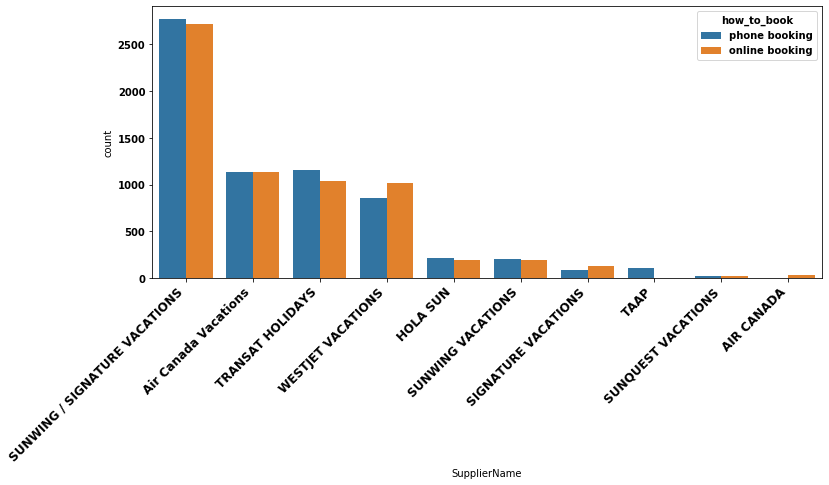

In [90]:
plt.subplots(figsize = (12,5))
sns.countplot(x=df_hotel_vacation['SupplierName'],order=df_hotel_vacation['SupplierName'].value_counts()[:10].index,hue=df_hotel_vacation['how_to_book'])
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
plt.show();

While each supplier received similar number of bookings online vs. by phone. Almost all of vacation packages supplied by TAAP were booked by phone. 

### K-Mode Clustering

Create bins for all the numeric features

In [92]:
df_hotel_vacation['length_of_stay_bin'] = pd.cut(df_hotel_vacation['length_of_stay'], [0, 3, 7, 14, 30, 373], 
                               labels=['0-3', '3-7', '7-14', '14-30','30-373'])

df_hotel_vacation['total_bin'] = pd.cut(df_hotel_vacation['Total'], [0, 2000, 3000, 4000, 5000, 32000], 
                              labels=['0-2000', '2000-3000', '3000-4000', '4000-5000','5000-32000'])

df_hotel_vacation['booking_window_bin'] = pd.cut(df_hotel_vacation['booking_window'], [-1, 30, 60, 90, 180, 680], 
                              labels=['0-30', '30-60', '60-90', '90-180','180-680'])
df_hotel_vacation['NumPax_bin'] = pd.cut(df_hotel_vacation['NumPax'], [-1, 2, 4, 6, 8, 18], 
                              labels=['-1-2', '2-4', '4-6', '6-8','8-18'])

In [93]:
df_hotel_vacation_1 = df_hotel_vacation[['NumPax_bin', 'total_bin', 'AirlineName', 'destination_city', 'holiday', 'checkin_day_of_week', 'booking_window_bin', 'length_of_stay_bin', 'Total', 'length_of_stay', 'booking_window', 'NumPax']]

In [94]:
df_hotel_vacation_1.isnull().sum()

NumPax_bin              0
total_bin               0
AirlineName            11
destination_city        0
holiday                 0
checkin_day_of_week     0
booking_window_bin      0
length_of_stay_bin      0
Total                   0
length_of_stay          0
booking_window          0
NumPax                  0
dtype: int64

In [95]:
df_hotel_vacation_clean_copy = df_hotel_vacation_1.copy()

In [96]:
df_hotel_vacation_clean = df_hotel_vacation[['NumPax_bin', 'total_bin', 'AirlineName', 'destination_city', 'holiday', 'checkin_day_of_week', 'booking_window_bin', 'length_of_stay_bin']]

In [97]:
from kmodes.kmodes import KModes
from sklearn import preprocessing

In [98]:
df_hotel_vacation_clean['AirlineName'].fillna('missing', inplace=True)

/opt/tljh/user/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [99]:
df_hotel_vacation_clean.isnull().sum()

NumPax_bin             0
total_bin              0
AirlineName            0
destination_city       0
holiday                0
checkin_day_of_week    0
booking_window_bin     0
length_of_stay_bin     0
dtype: int64

In [100]:
le = preprocessing.LabelEncoder()
df_hotel_vacation_clean = df_hotel_vacation_clean.apply(le.fit_transform)
df_hotel_vacation_clean.head()

NumPax_bin  total_bin  AirlineName  destination_city  holiday  \
0           0          2           20                41        2   
1           0          1           22                14        2   
2           0          3           22                40        2   
3           1          4           20                89        2   
4           0          0            5                89        2   

   checkin_day_of_week  booking_window_bin  length_of_stay_bin  
0                    4                   4                   4  
1                    2                   4                   2  
2                    3                   4                   4  
3                    2                   2                   2  
4                    4                   0                   2

In [101]:
cost = []
for num_clusters in list(range(1,6)):
    kmode = KModes(n_clusters=num_clusters, init = 'Cao', verbose=1)
    kmode.fit_predict(df_hotel_vacation_clean)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 52307.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 47750.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 44459.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 42901.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 42020.0


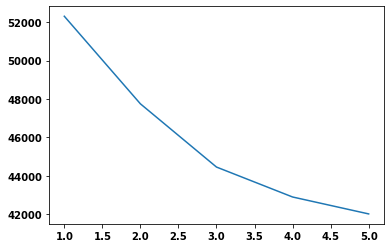

In [102]:
y = np.array([i for i in range(1,6,1)])
plt.plot(y,cost);

In [103]:
km_cao = KModes(n_clusters=3, init = "Cao", verbose=1)
fitClusters_cao = km_cao.fit_predict(df_hotel_vacation_clean)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 44459.0


In [104]:
df_hotel_vacation_clean = df_hotel_vacation_clean_copy.reset_index()

segment_df = pd.DataFrame(fitClusters_cao)
segment_df.columns = ['cluster_predicted']
combined_df = pd.concat([df_hotel_vacation_clean, segment_df], axis = 1).reset_index()
combined_df = combined_df.drop(['index', 'level_0'], axis = 1)

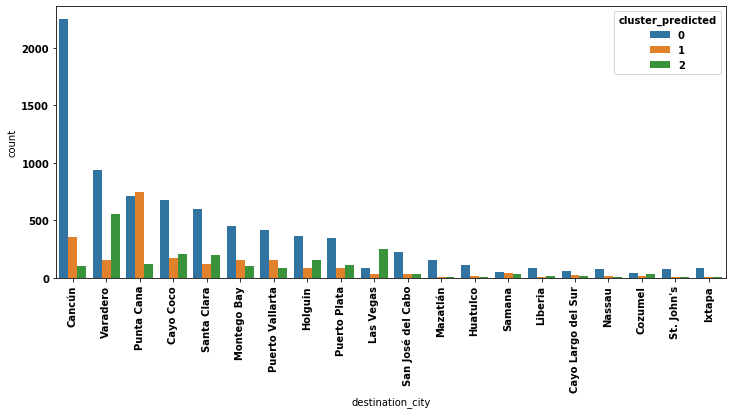

In [105]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['destination_city'],order=combined_df['destination_city'].value_counts()[:20].index,hue=combined_df['cluster_predicted'])
plt.xticks(rotation=90)
plt.show();

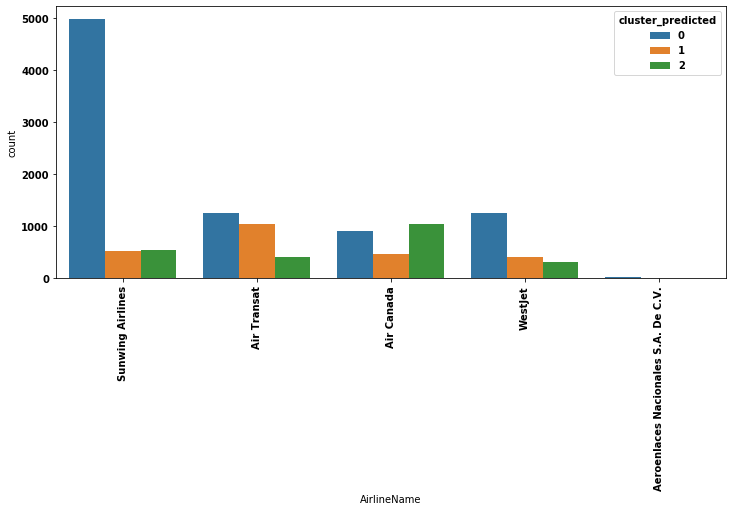

In [106]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['AirlineName'],order=combined_df['AirlineName'].value_counts()[:5].index,hue=combined_df['cluster_predicted'])
plt.xticks(rotation=90)
plt.show();

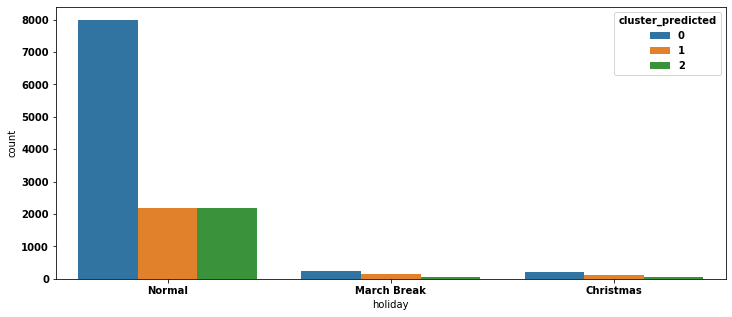

In [107]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['holiday'],order=combined_df['holiday'].value_counts().index,hue=combined_df['cluster_predicted'])
plt.show();

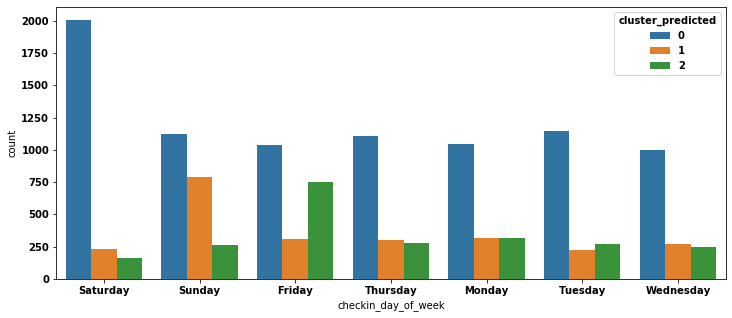

In [108]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['checkin_day_of_week'],order=combined_df['checkin_day_of_week'].value_counts().index,hue=combined_df['cluster_predicted'])
plt.show();

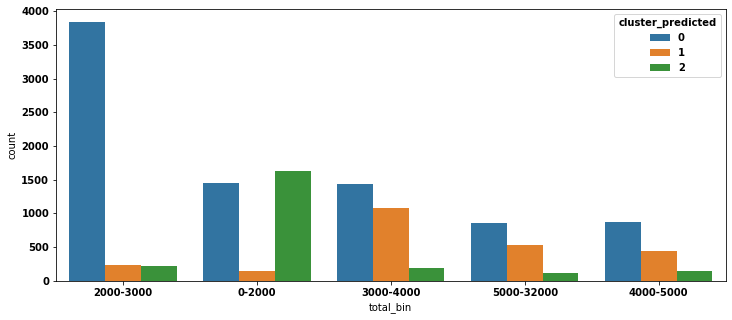

In [110]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['total_bin'],order=combined_df['total_bin'].value_counts().index,hue=combined_df['cluster_predicted'])
plt.show();

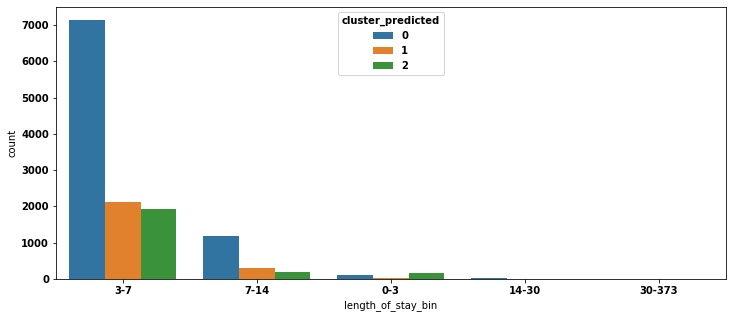

In [111]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['length_of_stay_bin'],order=combined_df['length_of_stay_bin'].value_counts().index,hue=combined_df['cluster_predicted'])
plt.show();

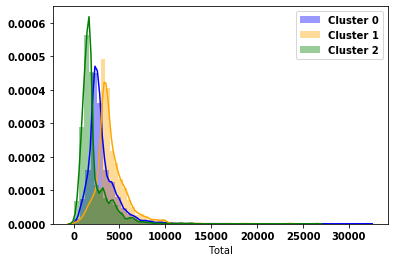

In [112]:
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 0]['Total'] , color="blue", label="Cluster 0")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 1]['Total'] , color="orange", label="Cluster 1")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 2]['Total'] , color="green", label="Cluster 2")
#plt.xlim(0, 3000)
plt.legend();

In [113]:
combined_df.loc[combined_df['cluster_predicted'] == 0]['Total'].describe()

count     8460.000000
mean      3099.663364
std       1693.624628
min         22.900000
25%       2179.955000
50%       2696.150000
75%       3608.312500
max      31986.000000
Name: Total, dtype: float64

In [114]:
combined_df.loc[combined_df['cluster_predicted'] == 1]['Total'].describe()

count     2448.000000
mean      4128.711675
std       1770.645276
min        191.950000
25%       3176.465000
50%       3724.745000
75%       4794.470000
max      23614.680000
Name: Total, dtype: float64

In [115]:
combined_df.loc[combined_df['cluster_predicted'] == 2]['Total'].describe()

count     2300.000000
mean      2128.934204
std       1546.063410
min         91.000000
25%       1277.020000
50%       1701.470000
75%       2413.692500
max      26452.700000
Name: Total, dtype: float64

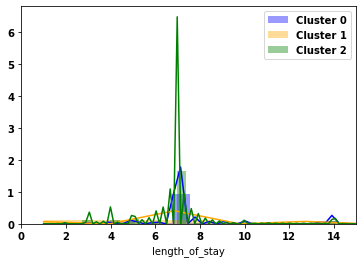

In [116]:
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 0]['length_of_stay'] , color="blue", label="Cluster 0")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 1]['length_of_stay'] , color="orange", label="Cluster 1")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 2]['length_of_stay'] , color="green", label="Cluster 2")
plt.xlim(0, 15)
plt.legend();

In [117]:
combined_df.loc[combined_df['cluster_predicted'] == 0]['length_of_stay'].describe()

count    8460.000000
mean        7.560402
std         2.460040
min         1.000000
25%         7.000000
50%         7.000000
75%         7.000000
max        42.000000
Name: length_of_stay, dtype: float64

In [118]:
combined_df.loc[combined_df['cluster_predicted'] == 1]['length_of_stay'].describe()

count    2448.000000
mean        7.451389
std         7.637908
min         1.000000
25%         7.000000
50%         7.000000
75%         7.000000
max       373.000000
Name: length_of_stay, dtype: float64

In [119]:
combined_df.loc[combined_df['cluster_predicted'] == 2]['length_of_stay'].describe()

count    2300.000000
mean        6.795652
std         2.199288
min         1.000000
25%         7.000000
50%         7.000000
75%         7.000000
max        21.000000
Name: length_of_stay, dtype: float64

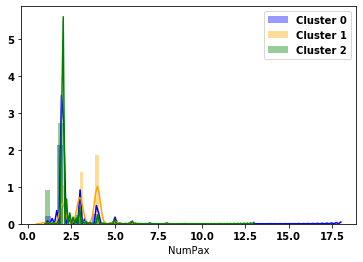

In [120]:
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 0]['NumPax'] , color="blue", label="Cluster 0")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 1]['NumPax'] , color="orange", label="Cluster 1")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 2]['NumPax'] , color="green", label="Cluster 2")
#plt.xlim(0, 30)
plt.legend();

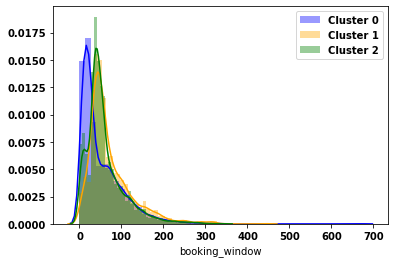

In [121]:
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 0]['booking_window'] , color="blue", label="Cluster 0")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 1]['booking_window'] , color="orange", label="Cluster 1")
sns.distplot(combined_df.loc[combined_df['cluster_predicted'] == 2]['booking_window'] , color="green", label="Cluster 2")
#plt.xlim(0, 30)
plt.legend();

## Vacation Flight Records
There might be some interesting details in the flight data here. Maybe we can come up with some insights about fare class and cabin.

Note that the TotalBuy column returns the price of the entire package not just the flight component.

In [81]:
vacation_flight_query = """
    select
        f.FOLDERNO,
        a.AIRREALNAME,
        a.FLIGHT,
        h.BookingDate,
        ARRIVALPT,
        f.NOOFPASS,
        a.CLASS,
        a.CLASSNAME,
        a.DEPCITY,
        a.ARRCITY,
        a.AIRDATE,
        a.ARRDATE,
        TOTALBuy,
        f.BOOKEDBY
    from dbo.FolderMaster f
    JOIN dbo.AirSegDetails a ON f.FOLDERNO = a.FOLDERNO
    JOIN dbo.HotelDetails h ON f.FOLDERNO = h.FOLDERNO and h.SLNO = 1
    join dbo.PassengerMaster p on f.FOLDERNO = p.FOLDERNO and p.SLNO = 1
    where
        CUSTOMERNAME = 'PC Travel'
        and f.STATUS in (1,2)
        and TOTALBuy > 0
        and lower(p.EMail) not like '%sandhurstconsulting.com'
        and lower(p.EMail) not like '%travelnationcanada.com'
        and lower(p.EMail) not like '%travelnation.com'
        and lower(p.EMail) not like '%pctravel.ca'
        and len(p.Email) > 0
        and len(ARRIVALPT) = 3
        and ISNUMERIC(ARRIVALPT) = 0
"""

In [82]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
with conn.cursor() as cur:
    cur.execute(vacation_flight_query)
    results = cur.fetchall()
conn.close()

In [83]:
columns =[
    'FolderNo',
    'AirlineName',
    'Flight',
    'BookingDate',
    'Destination',
    'NumPax',
    'Class',
    'Cabin',
    'DepCity',
    'ArrCity',
    'AirDate',
    'ArrDate',
    'Total',
    'BookedBy',
]
df_vacation_flight = pd.DataFrame.from_records(results, columns=columns)

In [84]:
df_vacation_flight.head(2)

FolderNo AirlineName Flight BookingDate Destination  NumPax Class    Cabin  \
0    61958     WestJet    438  2019-12-01         CUN       2     Y  Economy   
1    61958     WestJet   2736  2019-12-01         CUN       2     Y  Economy   

  DepCity ArrCity    AirDate    ArrDate      Total   BookedBy  
0     YEG     YYZ 2020-04-27 2020-04-27  3249.3400  PC Travel  
1     YYZ     CUN 2020-04-28 2020-04-28  3249.3400  PC Travel

In [184]:
df_vacation_flight['Cabin'].value_counts()

Economy                      19444
                              8839
Promotion                       40
Premium First                   39
Business                        35
Economy Class                   30
ECONOMY                         27
Business Class Discounted       10
Conditional Res                  9
Business Discounted              8
Tourist                          5
First                            5
Club Class                       2
Shuttle                          1
Name: Cabin, dtype: int64

In [137]:
customer_name_query = """
SELECT DISTINCT
    CONVERT(VARCHAR(32), HashBytes('MD5', CONVERT(varchar, LOWER(p.Email))), 2) hashed_email,
    CONVERT(VARCHAR(32), HashBytes('MD5', CONVERT(varchar, LOWER(p.FIRSTNAME ))), 2) hashed_firstname,
    CONVERT(VARCHAR(32), HashBytes('MD5', CONVERT(varchar, LOWER(p.LASTNAME ))), 2) hashed_lastname,
    CONVERT(VARCHAR(32), HashBytes('MD5', CONVERT(varchar, LOWER(p.TELEPHONE ))), 2) hashed_telephone,
    p.TITLE,
    p.TYPE,
    p.DOB,
    f.BOOKEDBY 
FROM FolderMaster f
JOIN PassengerMaster p ON f.PROJNO = p.PROJNO AND p.SLNO = 1
WHERE f.CUSTOMERNAME = 'PC Travel'
"""

In [138]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
with conn.cursor() as cur:
    cur.execute(customer_name_query)
    results = cur.fetchall()
conn.close()

In [139]:
columns =[
    'hashed_email',
    'hashed_firstname',
    'hashed_lastname',
    'hashed_telephone',
    'title',
    'type',
    'dob',
    'BookedBy',
]
df_customer = pd.DataFrame.from_records(results, columns=columns)

In [141]:
df_customer['title'] = df_customer['title'].str.upper()
df_customer['title'].replace('', 'unknown', regex=True, inplace=True)

df_customer.loc[df_customer['title'] == 'MR', 'gender'] = 'male' 
df_customer.loc[df_customer['title'] == 'MSTR', 'gender'] = 'male'
df_customer.loc[df_customer['title'] == 'DR', 'gender'] = 'male'
df_customer.loc[df_customer['title'] == 'DOCTOR', 'gender'] = 'male'
df_customer.loc[df_customer['title'] == 'MR.', 'gender'] = 'male'
df_customer.loc[df_customer['title'] == 'MASTER', 'gender'] = 'male'
df_customer.loc[df_customer['title'] == 'MS', 'gender'] = 'female'
df_customer.loc[df_customer['title'] == 'MRS', 'gender'] = 'female'
df_customer.loc[df_customer['title'] == 'MISS', 'gender'] = 'female'
df_customer.loc[df_customer['title'] == 'MIS', 'gender'] = 'female'
df_customer.loc[df_customer['title'] == 'UNSPECIFIED', 'gender'] = 'unknown'
df_customer.loc[df_customer['title'] == 'KELLY', 'gender'] = 'unknown'
df_customer.loc[df_customer['title'] == 'INFANT', 'gender'] = 'unknown'
df_customer.loc[df_customer['title'] == 'LADY', 'gender'] = 'female'
df_customer.loc[df_customer['title'] == '-', 'gender'] = 'unknown'
df_customer.loc[df_customer['title'] == 'LA', 'gender'] = 'female'

In [142]:
df_customer['gender'] = df_customer['gender'].fillna('unknown')
df_gender = df_customer.gender.value_counts().reset_index()
df_gender = df_gender.rename(columns={'index': 'gender', 'gender': 'count'})

In [143]:
df_gender

gender  count
0   female  23002
1     male  21972
2  unknown   2558

In [144]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=df_gender['gender'], values=df_gender['count'])])
fig.update_layout(title_text="Gender distribution")
fig.show()

In [145]:
now = pd.Timestamp('now')
df_customer = df_customer.loc[df_customer['dob']!=df_customer['dob'].max()]
df_customer['dob'] = pd.to_datetime(df_customer['dob'])
df_customer['age'] = (now - df_customer['dob']).astype('<m8[Y]')

28% of the customers were born on 1900-01-01. I decide to remove them.

In [146]:
df_customer = df_customer.loc[df_customer['age'] < 100]
df_customer['age_bin'] = pd.cut(df_customer['age'], [0, 2, 7, 22, 38, 54, 73, 99], 
                              labels=['Toddler (0-2)', 'Child (3-6)', 'Generation Z (7-22)', 'Millennials (23-38)','Generation X (39-54)', 'Boomers (55-73)', 'Silent (74-99)'])

In [147]:
df_age = df_customer.age_bin.value_counts().reset_index()
df_age = df_age.rename(columns={'index': 'age_group', 'age_bin': 'count'})

fig = go.Figure(data=[go.Pie(labels=df_age['age_group'], values=df_age['count'])])
fig.update_layout(title_text="Age group distribution")
fig.show()

In [148]:
df_customer.loc[df_customer['BookedBy'] == 'PC Travel', 'how_to_book'] = 'online booking'
df_customer.loc[df_customer['BookedBy'] != 'PC Travel', 'how_to_book'] = 'phone booking'

In [150]:
df_customer['age_bin'].value_counts()

Millennials (23-38)     12458
Generation X (39-54)    11428
Boomers (55-73)          8375
Generation Z (7-22)      1015
Silent (74-99)            889
Toddler (0-2)              19
Child (3-6)                 4
Name: age_bin, dtype: int64

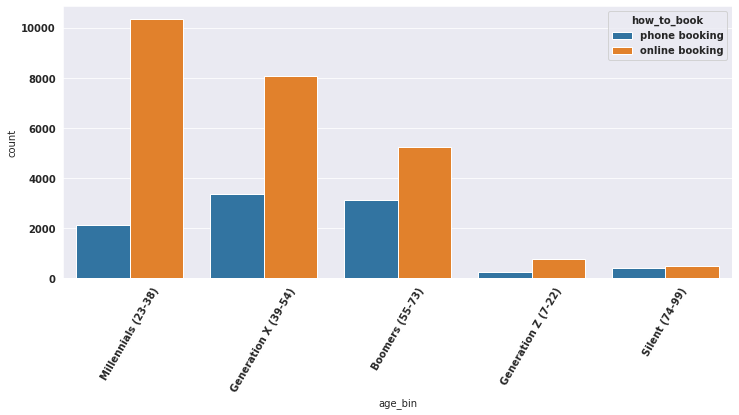

In [153]:
plt.subplots(figsize = (12,5))
sns.countplot(x=df_customer['age_bin'],order=df_customer['age_bin'].value_counts()[:5].index,hue=df_customer['how_to_book'])
plt.xticks(rotation=60)
# plt.title('How to make bookings by age group')
plt.show();